In [ ]:
# ============================================
# Enzyme EDA + Feature Engineering (Clean Script)
# --------------------------------------------
# Requirements (install once in your env):
#   pip install pandas numpy matplotlib seaborn pyarrow requests rdkit-pypi tqdm scipy statsmodels biopython scikit-learn
# ============================================
# ---------- Imports ----------
import os, io, re, requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import pyarrow.parquet as pq
from tqdm import tqdm
from scipy import stats

from Bio.SeqUtils.ProtParam import ProteinAnalysis
from rdkit import Chem
from rdkit.Chem import Descriptors, DataStructs, rdFingerprintGenerator
from rdkit import RDLogger

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold
from sklearn.impute import SimpleImputer
from functools import reduce
from typing import Optional
import umap

# ---------- Config ----------
FIG_DIR = "./figs"; os.makedirs(FIG_DIR, exist_ok=True)
DATA_URL = "https://github.com/ChemBioHTP/EnzyExtract/raw/main/data/export/TheData_kcat.parquet"

# Feature-reduction params
CORR_THRESHOLD = 0.90        # drop one of a pair if |corr| > 0.90 (continuous only)
FP_VAR_THRESHOLD = 0.01      # drop fingerprint bits with variance <= 0.01
USE_PCA_FOR_FP = True        # compress FP after variance filtering
FP_PCA_N_COMPONENTS = 200
RANDOM_STATE = 42

TARGET_COLS = ["kcat_km", "kcat_value", "km_value"]  # excluded from feature transforms

# ======================================================
# 1) Load & basic cleaning
# ======================================================
def load_data(url: str) -> pd.DataFrame:
    resp = requests.get(url); resp.raise_for_status()
    return pq.read_table(io.BytesIO(resp.content)).to_pandas()

enzy_data = load_data(DATA_URL)
# Keep parsed numeric columns; drop raw text duplicates
enzy_data = enzy_data.drop(columns=[c for c in ["kcat", "km"] if c in enzy_data.columns])
# Keep rows where kcat_value and km_value are defined
enzy_data = enzy_data.dropna(subset=["kcat_value", "km_value"]).reset_index(drop=True)

# # Drop columns with >50% missing (simple, defensible rule)
# missing_ratio = enzy_data.isnull().mean()
# enzy_data = enzy_data.drop(columns=missing_ratio[missing_ratio > 0.5].index)
# #Drop "Similariity" over 60%
# enzy_data = enzy_data[(enzy_data["max_enzyme_similarity"].isna()) | (enzy_data["max_enzyme_similarity"] >= 60)]
# enzy_data = enzy_data[(enzy_data["max_organism_similarity"].isna()) | (enzy_data["max_organism_similarity"] >= 60)]

print("[Data Load & Basic Cleaning] shape:", enzy_data.shape)


[Data Load & Basic Cleaning] shape: (178911, 33)


In [5]:
enzy_data.columns

Index(['enzyme', 'enzyme_full', 'substrate', 'substrate_full', 'mutant',
       'organism', 'kcat_km', 'temperature', 'pH', 'solution', 'cofactors',
       'other', 'descriptor', 'pmid', 'canonical', 'clean_mutant', 'cid',
       'brenda_id', 'smiles', 'cid_full', 'brenda_id_full', 'enzyme_ecs',
       'enzyme_ecs_full', 'kcat_value', 'km_value', 'sequence',
       'sequence_source', 'uniprot', 'ncbi', 'pdb', 'max_enzyme_similarity',
       'max_organism_similarity', 'total_similarity'],
      dtype='object')

In [ ]:
# ============================================
# Enzyme EDA + Feature Engineering (Clean Script)
# --------------------------------------------
# Requirements (install once in your env):
#   pip install pandas numpy matplotlib seaborn pyarrow requests rdkit-pypi tqdm scipy statsmodels biopython scikit-learn
# ============================================
# ---------- Imports ----------
import os, io, re, requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import pyarrow.parquet as pq
from tqdm import tqdm
from scipy import stats

from Bio.SeqUtils.ProtParam import ProteinAnalysis
from rdkit import Chem
from rdkit.Chem import Descriptors, DataStructs, rdFingerprintGenerator
from rdkit import RDLogger

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold
from sklearn.impute import SimpleImputer
from functools import reduce
from typing import Optional
import umap

# ---------- Config ----------
FIG_DIR = "./figs"; os.makedirs(FIG_DIR, exist_ok=True)
DATA_URL = "https://github.com/ChemBioHTP/EnzyExtract/raw/main/data/export/TheData_kcat.parquet"

# Feature-reduction params
CORR_THRESHOLD = 0.90        # drop one of a pair if |corr| > 0.90 (continuous only)
FP_VAR_THRESHOLD = 0.01      # drop fingerprint bits with variance <= 0.01
USE_PCA_FOR_FP = True        # compress FP after variance filtering
FP_PCA_N_COMPONENTS = 200
RANDOM_STATE = 42

TARGET_COLS = ["kcat_km", "kcat_value", "km_value"]  # excluded from feature transforms

# ======================================================
# 1) Load & basic cleaning
# ======================================================
def load_data(url: str) -> pd.DataFrame:
    resp = requests.get(url); resp.raise_for_status()
    return pq.read_table(io.BytesIO(resp.content)).to_pandas()

enzy_data = load_data(DATA_URL)
# Keep parsed numeric columns; drop raw text duplicates
enzy_data = enzy_data.drop(columns=[c for c in ["kcat", "km"] if c in enzy_data.columns])
# Keep rows where kcat_value and km_value are defined
enzy_data = enzy_data.dropna(subset=["kcat_value", "km_value"]).reset_index(drop=True)

# Drop columns with >50% missing (simple, defensible rule)
missing_ratio = enzy_data.isnull().mean()
enzy_data = enzy_data.drop(columns=missing_ratio[missing_ratio > 0.5].index)
#Drop "Similariity" over 60%
enzy_data = enzy_data[(enzy_data["max_enzyme_similarity"].isna()) | (enzy_data["max_enzyme_similarity"] >= 60)]
enzy_data = enzy_data[(enzy_data["max_organism_similarity"].isna()) | (enzy_data["max_organism_similarity"] >= 60)]

print("[Data Load & Basic Cleaning] shape:", enzy_data.shape)

# ======================================================
# 2) Temperature parsing (to °C) and pH parsing
# ======================================================
def extract_numeric_segment(text: str):
    """Return (numeric_part, had_unit). Keeps '±' part, ignores trailing unit text."""
    if not text: return "", False
    t = str(text).strip().replace("×", "x").replace("X", "x")
    t = re.sub(r"\s+", " ", t)
    m = re.match(r"^\s*([\d\.\+\-eExx^ ]+(?:\s*(?:±|[-–—to])\s*[\d\.\+\-eExx^ ]+)?)\s*(.*)$", t, re.IGNORECASE)
    if not m: return t, False
    return m.group(1).strip(), bool(m.group(2).strip())

def _convert_token(tok: str):
    """Convert '1.3e4', '2x10^3' → float; else NaN."""
    if not tok: return np.nan
    t = str(tok).strip().lower().replace("×", "x").replace("–", "-").replace("—", "-").replace("−", "-")
    try: return float(t)
    except ValueError: pass
    m = re.match(r"([\+\-]?\d*\.?\d+)\s*[x]\s*10\^?([\+\-]?\d+)", t)
    return float(m.group(1)) * (10 ** int(m.group(2))) if m else np.nan

def parse_numeric_or_range(s: str):
    """Return midpoint for ranges, single value for ±, NaN if fail."""
    if not s: return np.nan
    t = str(s)
    t = t.replace("×","x").replace("–","-").replace("—","-").replace("−","-")
    t = re.sub(r"\s+", " ", t); t = re.sub(r"\bto\b", "-", t, flags=re.I)
    t = re.sub(r"\s*±\s*[\d\.eE\+\-]+", "", t)  # drop ± error
    tokens = re.findall(r"([\+\-]?\d*\.?\d+(?:[eE][\+\-]?\d+)?|[\+\-]?\d*\.?\d+\s*x\s*10\^?[\+\-]?\d+)", t)
    if not tokens: return np.nan
    if len(tokens) == 1: return _convert_token(tokens[0])
    lo, hi = _convert_token(tokens[0]), _convert_token(tokens[1])
    return (lo + hi) / 2.0 if np.isfinite(lo) and np.isfinite(hi) else np.nan

def _detect_temp_unit(text: str):
    """Return ('C'|'K'|'F'|None, factor, offset) to convert to °C."""
    if re.search(r"[°\s]*c\b", text, re.I): return "C", 1.0, 0.0
    if re.search(r"[°\s]*k\b", text, re.I): return "K", 1.0, -273.15
    if re.search(r"[°\s]*f\b", text, re.I): return "F", 5/9, -32 * 5/9
    return None, None, None

def preprocess_temperature_field(text):
    """Remove pH snippets; map 'room temperature' to ~22°C unless explicit number given."""
    if pd.isna(text): return np.nan
    t = str(text).strip().lower()
    t = re.sub(r"ph\s*\d+(\.\d+)?\s*,?\s*", "", t)
    if "room temperature" in t or "ambient temperature" in t or re.search(r"\brt\b", t):
        m = re.search(r"(\d+(\.\d+)?)\s*°?\s*c", t)
        return (m.group(1) + "°C") if m else "22°C"
    if "not mentioned" in t: return np.nan
    return t.strip(" ,;()[]")

temp_counts = {"valid": 0, "unavailable": 0, "failed": 0, "unrecognized": 0}

def clean_temperature(value):
    """Parse '37 °C', '310 K', '30 ± 2°C', '20-25 °C' → °C (float)."""
    if pd.isna(value) or str(value).strip()=="":
        temp_counts["unavailable"] += 1; return np.nan
    text = str(value)
    numeric_seg, had_unit = extract_numeric_segment(text)
    val = parse_numeric_or_range(numeric_seg)
    if not np.isfinite(val): temp_counts["failed"] += 1; return np.nan
    unit, factor, offset = _detect_temp_unit(text)
    if unit == "C": temp_counts["valid"] += 1; return val
    if unit == "K": temp_counts["valid"] += 1; return val - 273.15
    if unit == "F": temp_counts["valid"] += 1; return (val - 32) * 5/9
    if not had_unit: return val  # assume °C by convention
    temp_counts["unrecognized"] += 1; return np.nan

enzy_data["temperature_pre"] = enzy_data.get("temperature", pd.Series(index=enzy_data.index)).apply(preprocess_temperature_field)
enzy_data["temperature_C"] = enzy_data["temperature_pre"].apply(clean_temperature)

# pH cleaner (simple numeric/range + a few qualitative words)
ph_counts = {"valid": 0, "failed": 0, "unavailable": 0, "unrecognized": 0}

def clean_ph(value):
    if pd.isna(value) or str(value).strip()=="":
        ph_counts["unavailable"] += 1; return np.nan
    t = str(value).strip().lower()
    if any(x in t for x in ["unknown", "n/a", "—", "–"]):
        ph_counts["unavailable"] += 1; return np.nan
    if "neutral" in t: return 7.0
    if "acidic" in t:  return 5.0
    if "basic"  in t or "alkaline" in t: return 9.0
    m = re.match(r"p?h?\s*([\d\.]+)\s*[-–to]+\s*([\d\.]+)", t)
    if m:
        try: low, high = float(m.group(1)), float(m.group(2)); ph_counts["valid"] += 1; return (low + high)/2
        except: ph_counts["failed"] += 1; return np.nan
    m = re.match(r"p?h?\s*([\d\.]+)", t)
    if m:
        try: v = float(m.group(1)); ph_counts["valid"] += 1; return v
        except: ph_counts["failed"] += 1; return np.nan
    ph_counts["unrecognized"] += 1; return np.nan

enzy_data["pH_value"] = enzy_data.get("pH", pd.Series(index=enzy_data.index)).apply(clean_ph)
print("[Temperature (to °C) and pH parsing] shape:", enzy_data.shape)
# ======================================================
# 3) Sequence features (ProteinAnalysis) with robust cleaning
# ======================================================
STD = set("ACDEFGHIKLMNPQRSTVWY")
REPLACEMENTS = {
    "U": "C",  # selenocysteine -> cysteine proxy
    "O": "K",  # pyrrolysine -> lysine proxy
    "B": "D",  # D/N ambiguity -> aspartate
    "Z": "E",  # E/Q ambiguity -> glutamate
    "J": "L",  # I/L ambiguity -> leucine
}
paren_pat = re.compile(r"\([^)]*\)")

def normalize_sequence(seq: str):
    s = str(seq)
    s = paren_pat.sub("", s)
    s = re.sub(r"\s+", "", s)
    s = re.sub(r"[^A-Za-z]", "", s).upper()
    for k,v in REPLACEMENTS.items(): s = s.replace(k, v)
    orig_len = len(s)
    s_clean = "".join(ch for ch in s if ch in STD)
    unknown_frac = (1 - len(s_clean)/orig_len) if orig_len else np.nan
    return s_clean, unknown_frac, orig_len

def compute_protein_features(seq):
    s_clean, unknown_frac, orig_len = normalize_sequence(seq)
    if not s_clean or orig_len < 10:
        return {}
    pa = ProteinAnalysis(s_clean)
    feats = {
        "sequence_length": orig_len,
        "clean_length": len(s_clean),
        "unknown_frac": unknown_frac,
        "aromaticity": pa.aromaticity(),
        "instability_index": pa.instability_index(),
        "isoelectric_point": pa.isoelectric_point(),
        "gravy": pa.gravy(),
    }
    h, t, e = pa.secondary_structure_fraction()
    feats.update({"frac_helix": h, "frac_turn": t, "frac_sheet": e})

    # was: pa.get_amino_acids_percent()  -> deprecated
    for aa, frac in pa.amino_acids_percent.items():
        feats[f"aa_{aa}"] = frac
    return feats

seq_feats = [compute_protein_features(s) for s in tqdm(enzy_data.get("sequence", pd.Series(index=enzy_data.index)).astype(str), desc="Sequence feats")]
enzy_data = pd.concat([enzy_data.reset_index(drop=True), pd.DataFrame(seq_feats).reset_index(drop=True)], axis=1)

print("[Sequence feature computation] shape:", enzy_data.shape)

# ======================================================
# 4) SMILES → RDKit descriptors + Morgan fingerprints
# ======================================================
RDLogger.DisableLog('rdApp.*')         # suppress RDKit warnings
FP_SIZE = 2048
morgan_gen = rdFingerprintGenerator.GetMorganGenerator(radius=2, fpSize=FP_SIZE)

def smiles_to_mol(s): 
    try: return Chem.MolFromSmiles(s, sanitize=True)
    except: return None

def mol_descriptors(mol):
    if mol is None:
        return pd.Series({"MW": np.nan, "LogP": np.nan, "NumHDonors": np.nan, "NumHAcceptors": np.nan,
                          "TPSA": np.nan, "RotBonds": np.nan, "AromaticRingCount": np.nan, "RingCount": np.nan})
    return pd.Series({
        "MW": Descriptors.MolWt(mol),
        "LogP": Descriptors.MolLogP(mol),
        "NumHDonors": Descriptors.NumHDonors(mol),
        "NumHAcceptors": Descriptors.NumHAcceptors(mol),
        "TPSA": Descriptors.TPSA(mol),
        "RotBonds": Descriptors.NumRotatableBonds(mol),
        "AromaticRingCount": Descriptors.NumAromaticRings(mol),
        "RingCount": Descriptors.RingCount(mol),
    })

def mol_fingerprint(mol, generator=morgan_gen, nbits=FP_SIZE):
    if mol is None: return np.zeros(nbits, dtype=int)
    fp = generator.GetFingerprint(mol)
    arr = np.zeros((nbits,), dtype=int)
    DataStructs.ConvertToNumpyArray(fp, arr)
    return arr

enzy_data["mol"] = enzy_data.get("smiles", pd.Series(index=enzy_data.index)).apply(smiles_to_mol)
desc_df = enzy_data["mol"].apply(mol_descriptors).add_prefix("desc_")
fps = np.vstack(enzy_data["mol"].apply(mol_fingerprint))
fp_df = pd.DataFrame(fps, columns=[f"fp_{i}" for i in range(fps.shape[1])])

# add log scaling for MW, TFSA due to right skew
desc_df["desc_log_MW"] = np.log10(desc_df["desc_MW"])
desc_df["desc_log_TPSA"] = np.log1p(desc_df["desc_TPSA"])

# drop original mol column
desc_df = desc_df.drop(columns=["desc_MW", "desc_TPSA",])

enzy_data = pd.concat([enzy_data.reset_index(drop=True), desc_df.reset_index(drop=True), fp_df], axis=1)

print("[Molecule descriptors and fingerprints] shape:", enzy_data.shape)

# ======================================================
# 5) Feature pruning (corr on continuous; variance + PCA on fingerprints)
# ======================================================
def split_feature_blocks(df: pd.DataFrame):
    num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    num_cols = [c for c in num_cols if c not in TARGET_COLS]
    fp_cols = [c for c in num_cols if c.startswith("fp_")]
    cont_cols = [c for c in num_cols if c not in fp_cols]
    return cont_cols, fp_cols

def correlation_prune(df: pd.DataFrame, cols: list, thr: float):
    if not cols: return []
    corr = df[cols].corr().abs()
    upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
    to_drop = [c for c in upper.columns if any(upper[c] > thr)]
    kept = [c for c in cols if c not in to_drop]
    print(f"[Correlation prune] {len(cols)} → keep {len(kept)} (thr={thr})")
    return kept

def reduce_fps(df: pd.DataFrame, fp_cols: list, var_thr=0.01, use_pca=False, pca_n=256, rs=42):
    if not fp_cols: 
        return np.empty((len(df), 0)), [], {"vt": None, "pca": None}
    X = df[fp_cols].fillna(0).astype(np.float32).values
    vt = VarianceThreshold(threshold=var_thr)
    Xr = vt.fit_transform(X)
    kept_mask = vt.get_support()
    kept_cols = [c for c, keep in zip(fp_cols, kept_mask) if keep]
    print(f"[FP variance] {len(fp_cols)} → keep {Xr.shape[1]} (thr={var_thr})")
    pca_model, names = None, kept_cols
    if use_pca and Xr.shape[1] > 0:
        print(f"[FP PCA] applying PCA to reduce to {pca_n} components")
        pca_model = PCA(n_components=min(pca_n, Xr.shape[1]), random_state=rs)
        Xr = pca_model.fit_transform(Xr)
        names = [f"fp_pca_{i}" for i in range(Xr.shape[1])]
        print(f"[FP PCA] reduced to {Xr.shape[1]} comps")
    return Xr, names, {"vt": vt, "pca": pca_model, "mask": kept_mask}

def prepare_features(df_in: pd.DataFrame):
    df = df_in.copy()
    y = {t: df[t].values if t in df.columns else None for t in TARGET_COLS}
    cont_cols, fp_cols = split_feature_blocks(df)
    cont_keep = correlation_prune(df, cont_cols, CORR_THRESHOLD)

    cont_imp = SimpleImputer(strategy="median")
    cont_scaler = StandardScaler()
    X_cont = cont_scaler.fit_transform(cont_imp.fit_transform(df[cont_keep])) if cont_keep else np.empty((len(df), 0))

    X_fp, fp_names, fp_steps = reduce_fps(df, fp_cols, FP_VAR_THRESHOLD, USE_PCA_FOR_FP, FP_PCA_N_COMPONENTS, RANDOM_STATE)
    X = np.hstack([X_cont, X_fp]) if X_fp.size else X_cont
    meta = {
        "cont_cols_in": cont_cols, "cont_cols_kept": cont_keep,
        "fp_cols_in": fp_cols, "fp_cols_kept": fp_names,
        "imputer": cont_imp, "scaler": cont_scaler,
        "fp_var_selector": fp_steps["vt"], "fp_pca": fp_steps["pca"], "fp_mask": fp_steps.get("mask"),
    }
    print(f"[Final features] fp_pca: {meta['fp_pca'] is not None}")
    print(f"[Final features] X shape: {X.shape}")
    return X, y, meta

print("[Feature pruning] shape:", enzy_data.shape)

# ======================================================
# 6) Plots for reporting (pre/post corr; FP variance; PCA scree)
# ======================================================
def plot_corr_heatmap(df, cols, title, fname, sample_max=5000):
    if not cols: return
    sub = df[cols]
    if len(sub) > sample_max: sub = sub.sample(sample_max, random_state=42)
    corr = sub.corr()
    plt.figure(figsize=(10,8))
    sns.heatmap(corr, cmap="coolwarm", vmin=-1, vmax=1, xticklabels=False, yticklabels=False)
    plt.title(title); plt.tight_layout()
    out = os.path.join(FIG_DIR, fname); plt.savefig(out, dpi=200); plt.close(); print("[saved]", out)

def plot_pca_explained_variance(pca_model, fname="fp_pca_explained_variance.png"):
    """
    Scree plot for PCA on fingerprints with legend and 95% variance threshold line.
    """
    if pca_model is None:
        return

    evr = pca_model.explained_variance_ratio_
    cum = np.cumsum(evr)

    plt.figure(figsize=(6, 4))
    plt.plot(range(1, len(evr)+1), evr, marker="o", label="Per-component variance")
    plt.plot(range(1, len(evr)+1), cum, marker=".", label="Cumulative variance")

    # Add horizontal line at 0.95 cumulative explained variance
    plt.axhline(y=0.95, color="red", linestyle="--", linewidth=1, label="95% variance threshold")

    plt.xlabel("PCA component")
    plt.ylabel("Explained variance (ratio)")
    plt.title("FP PCA: explained variance (per-comp and cumulative)")
    plt.legend()
    plt.tight_layout()

    out = os.path.join(FIG_DIR, fname)
    plt.savefig(out, dpi=200)
    plt.close()
    print(f"[saved] {out}")


def plot_fp_variance_and_kept(fps_df, kept_mask, title_prefix="FP",
                              var_threshold=0.01, fname_prefix="fp"):
    """
    Histogram of fingerprint bit variances + bar for kept vs dropped.
    """
    if fps_df.empty:
        return
    X = fps_df.fillna(0).astype(np.float32).values
    vars_ = X.var(axis=0)

    # 1) Variance histogram
    plt.figure(figsize=(6,4))
    plt.hist(vars_, bins=50)
    plt.axvline(var_threshold, linestyle="--")
    plt.title(f"{title_prefix}: Bit Variance Distribution")
    plt.xlabel("Variance")
    plt.ylabel("Count of bits")
    plt.tight_layout()
    out1 = os.path.join(FIG_DIR, f"{fname_prefix}_variance_hist.png")
    plt.savefig(out1, dpi=200)
    plt.close()
    print(f"[saved] {out1}")

    # 2) Kept vs dropped bar
    kept = int(kept_mask.sum())
    dropped = int((~kept_mask).sum())
    plt.figure(figsize=(4,4))
    plt.bar(["kept", "dropped"], [kept, dropped])
    plt.title(f"{title_prefix}: Kept vs Dropped (var>{var_threshold})")
    plt.tight_layout()
    out2 = os.path.join(FIG_DIR, f"{fname_prefix}_kept_dropped.png")
    plt.savefig(out2, dpi=200)
    plt.close()
    print(f"[saved] {out2}")

def plot_pca_scree(pca_model, fname="fp_pca_explained_variance.png"):
    if pca_model is None: return
    evr = pca_model.explained_variance_ratio_; cum = np.cumsum(evr)
    plt.figure(figsize=(6,4))
    plt.plot(range(1, len(evr)+1), evr, marker="o")
    plt.plot(range(1, len(evr)+1), cum, marker=".")
    plt.xlabel("PCA component"); plt.ylabel("Explained variance (ratio)")
    plt.title("FP PCA: explained variance (per-comp and cumulative)")
    plt.tight_layout()
    out = os.path.join(FIG_DIR, fname); plt.savefig(out, dpi=200); plt.close(); print("[saved]", out)


# ======================================================
# 7) Outlier detection and removal
# ======================================================
import numpy as np
import pandas as pd
from sklearn.ensemble import IsolationForest

# ---------- helpers ----------
def log_iqr_bounds(s: pd.Series, fence: float = 1.5):
    s = pd.to_numeric(s, errors="coerce")
    s = s[s > 0]  # log requires positive
    if s.empty:
        return None, None
    x = np.log10(s)
    q1, q3 = np.nanpercentile(x, [25, 75])
    iqr = q3 - q1
    lo, hi = q1 - fence * iqr, q3 + fence * iqr
    return lo, hi  # bounds on log10 scale

def flag_outliers_log_iqr(s: pd.Series, fence: float = 1.5) -> pd.Series:
    s = pd.to_numeric(s, errors="coerce")
    mask_pos = s > 0
    out = pd.Series(False, index=s.index, dtype=bool)
    if not mask_pos.any():
        return out
    x = np.log10(s[mask_pos])
    q1, q3 = np.nanpercentile(x, [25, 75])
    iqr = q3 - q1
    lo, hi = q1 - fence * iqr, q3 + fence * iqr
    bad = (x < lo) | (x > hi)
    out.loc[bad.index] = bad.values
    return out.astype(bool)

def percentile_clip(s: pd.Series, lo=0.1, hi=99.9):
    s = pd.to_numeric(s, errors="coerce")
    p_lo, p_hi = np.nanpercentile(s.dropna(), [lo, hi]) if s.notna().any() else (np.nan, np.nan)
    return s.clip(lower=p_lo, upper=p_hi)

# ---------- 1) domain-rule mask ----------
def domain_outlier_mask(df: pd.DataFrame):
    m = pd.Series(False, index=df.index)
    if "pH_value" in df:
        m |= (df["pH_value"] <= 0) | (df["pH_value"] > 14)
    if "temperature_C" in df:
        m |= (df["temperature_C"] < -10) | (df["temperature_C"] > 120)
    if "kcat_value" in df:
        m |= (df["kcat_value"] <= 0)
    if "km_value" in df:
        m |= (df["km_value"] <= 0)
    if "unknown_frac" in df:
        m |= (df["unknown_frac"] > 0.2)
    return m

# ---------- 2) log-IQR mask on kinetics ----------
# def kinetics_outlier_mask(df: pd.DataFrame, fence=1.5, per_group=None) -> pd.Series:
#     cols = [c for c in ["kcat_value", "km_value"] if c in df.columns]
#     out = pd.Series(False, index=df.index, dtype=bool)

#     def mask_for_subset(sub):
#         m = pd.Series(False, index=sub.index, dtype=bool)
#         for c in cols:
#             m |= flag_outliers_log_iqr(sub[c], fence=fence)
#         if {"kcat_value","km_value"}.issubset(sub.columns):
#             ratio = sub["kcat_value"] / sub["km_value"]
#             m |= flag_outliers_log_iqr(ratio, fence=fence)
#         return m.astype(bool)

#     if per_group and per_group in df.columns:
#         for _, sub in df.groupby(per_group):
#             mg = mask_for_subset(sub)
#             out.loc[mg.index] |= mg
#     else:
#         out |= mask_for_subset(df)

#     # ensure strictly boolean, NaN->False
#     return out.fillna(False).astype(bool)

def kinetics_outlier_mask(
    df: pd.DataFrame,
    fence: float = 1.5,
    # per_group: str | None = "enzyme",
    per_group: Optional[str] = "enzyme",   
    *,
    adaptive: bool = True,
    target_rate: float = 0.05,                 # aim to flag ≤ 5% per group
    fence_grid: tuple = (1.5, 2.0, 2.5, 3.0, 3.5, 4.0),
    min_group_size: int = 50,                  # don’t adapt tiny groups
    use_ratio: bool = True,
    verbose: bool = False
) -> pd.Series:
    """
    Kinetics outlier mask using log-IQR on kcat, km (and optionally kcat/km).
    - Operates per-group (e.g., per enzyme) when `per_group` is provided.
    - If `adaptive=True`, it *loosens* the IQR fence within `fence_grid`
      until the outlier rate ≤ target_rate for that group.
    - Falls back to MAD rule if the grid can’t hit target_rate (rare on tiny/peculiar groups).
    Returns a boolean Series indexed like df (True = outlier).
    """
    def _log_values(s: pd.Series) -> pd.Series:
        s = pd.to_numeric(s, errors="coerce")
        s = s[(s > 0) & np.isfinite(s)]
        return np.log10(s)

    def _iqr_mask(x_log: pd.Series, f: float) -> pd.Series:
        if x_log.empty:
            return pd.Series(False, index=x_log.index)
        q1, q3 = np.nanpercentile(x_log, [25, 75])
        iqr = q3 - q1
        lo, hi = q1 - f * iqr, q3 + f * iqr
        return (x_log < lo) | (x_log > hi)

    def _mad_mask(x_log: pd.Series, k: float = 5.0) -> pd.Series:
        # robust fallback: |x - median| / (1.4826 * MAD) > k
        if x_log.empty:
            return pd.Series(False, index=x_log.index)
        med = np.nanmedian(x_log)
        mad = np.nanmedian(np.abs(x_log - med))
        if mad == 0 or not np.isfinite(mad):
            return pd.Series(False, index=x_log.index)
        z = np.abs(x_log - med) / (1.4826 * mad)
        return z > k

    # Prepare columns
    have_kcat = "kcat_value" in df.columns
    have_km   = "km_value" in df.columns
    if not (have_kcat and have_km):
        return pd.Series(False, index=df.index, dtype=bool)

    # Precompute ratio safely
    ratio = None
    if use_ratio:
        num = pd.to_numeric(df["kcat_value"], errors="coerce")
        den = pd.to_numeric(df["km_value"],   errors="coerce")
        with np.errstate(divide="ignore", invalid="ignore"):
            ratio = num / den
        ratio[~np.isfinite(ratio)] = np.nan

    # Work either globally or per group
    groups = [(None, df)] if not per_group or per_group not in df.columns else df.groupby(per_group, dropna=False)

    out_mask = pd.Series(False, index=df.index, dtype=bool)

    for gname, sub in groups:
        idx = sub.index
        x_kcat = _log_values(sub["kcat_value"])
        x_km   = _log_values(sub["km_value"])
        x_ratio = _log_values(ratio.loc[idx]) if (use_ratio and ratio is not None) else pd.Series([], dtype=float)

        # If too small, just use global fence (no adaptation)
        adapt = adaptive and (len(idx) >= min_group_size)

        # Try fences from tight → loose until ≤ target_rate
        chosen_fence = fence
        def _compose_mask(f):
            m = pd.Series(False, index=idx, dtype=bool)
            if not x_kcat.empty: m |= _iqr_mask(x_kcat, f).reindex(idx, fill_value=False)
            if not x_km.empty:   m |= _iqr_mask(x_km,   f).reindex(idx, fill_value=False)
            if not x_ratio.empty: m |= _iqr_mask(x_ratio, f).reindex(idx, fill_value=False)
            return m

        if adapt:
            m_try = None
            for f in fence_grid:
                m_tmp = _compose_mask(f)
                rate = m_tmp.mean() if len(m_tmp) else 0.0
                if rate <= target_rate:
                    chosen_fence, m_try = f, m_tmp
                    break
            if m_try is None:
                # fallback to MAD-based rule when grid can’t achieve target
                m_mad = pd.Series(False, index=idx, dtype=bool)
                if not x_kcat.empty:  m_mad |= _mad_mask(x_kcat).reindex(idx, fill_value=False)
                if not x_km.empty:    m_mad |= _mad_mask(x_km).reindex(idx, fill_value=False)
                if not x_ratio.empty: m_mad |= _mad_mask(x_ratio).reindex(idx, fill_value=False)
                m_try = m_mad
            m_g = m_try
        else:
            m_g = _compose_mask(fence)

        out_mask.loc[idx] = m_g

        if verbose:
            n = len(idx)
            r = m_g.mean()*100 if n else 0.0
            print(f"[kinetics] group={gname!r:>12} n={n:6d}  fence={chosen_fence:.1f}{' (MAD)' if adapt and m_try is m_g and chosen_fence==fence and r>target_rate*100 else ''}  outliers={int(m_g.sum()):5d} ({r:4.1f}%)")

    # Ensure boolean with NaN→False
    return out_mask.fillna(False).astype(bool)

def compute_sequential_drop_masks(
    df: pd.DataFrame,
    fence: float = 1.5,
    contamination: float = 0.01,
    per_group: str = "enzyme",
) -> dict:
    """
    Return boolean Series (aligned to df.index) that mark rows *actually dropped*
    by apply_outlier_strategy order: domain → kinetics → iso.
    Keys: 'domain_drop', 'kinetics_drop', 'iso_drop', 'kept'
    """
    # A) domain
    m_domain = domain_outlier_mask(df).fillna(False).astype(bool)

    # B) kinetics on the remaining rows
    df1 = df[~m_domain].copy()
    m_kin_sub = kinetics_outlier_mask(df1, fence=fence, per_group=per_group)
    m_kin = pd.Series(False, index=df.index, dtype=bool)
    m_kin.loc[df1.index] = m_kin_sub.values

    # C) iso on the remaining rows
    df2 = df1[~m_kin_sub].copy()
    cont_cols = df2.select_dtypes(include=[np.number]).columns.tolist()
    cont_cols = [c for c in cont_cols if not c.startswith("fp_")]
    m_iso_sub = iso_forest_mask(df2, cont_cols, cont_rate=contamination)
    m_iso = pd.Series(False, index=df.index, dtype=bool)
    m_iso.loc[df2.index] = m_iso_sub.values

    kept = ~(m_domain | m_kin | m_iso)
    return {
        "domain_drop": m_domain,
        "kinetics_drop": m_kin,
        "iso_drop": m_iso,
        "kept": kept,
    }

def plot_kcat_km_scatter_drops(
    df: pd.DataFrame,
    drop_masks: dict,                     # from compute_sequential_drop_masks(...)
    fname: str = "scatter_kcat_km_drops.png",
    show_regular: bool = True,            # draw kept points as a 4th color
    sample_regular: Optional[int] = 5000, # None=all kept, int=subsample, 0=hide
    regular_alpha: float = 0.5
):
    # --- filter to values we can actually plot on log axes ---
    d = df[(pd.to_numeric(df["kcat_value"], errors="coerce") > 0) &
           (pd.to_numeric(df["km_value"],   errors="coerce") > 0)].copy()
    d["log_kcat"] = np.log10(d["kcat_value"])
    d["log_km"]   = np.log10(d["km_value"])

    # reindex masks to plotted subset
    m_dom_all = drop_masks["domain_drop"]   # full-data mask
    m_kin_all = drop_masks["kinetics_drop"]
    m_iso_all = drop_masks["iso_drop"]
    m_keep_all= drop_masks["kept"]

    # totals across full df (for legend)
    n_dom_all = int(m_dom_all.sum())
    n_kin_all = int(m_kin_all.sum())
    n_iso_all = int(m_iso_all.sum())
    n_keep_all= int(m_keep_all.sum())

    # masks restricted to the scatterable subset
    m_dom = m_dom_all.reindex(d.index, fill_value=False)
    m_kin = m_kin_all.reindex(d.index, fill_value=False)
    m_iso = m_iso_all.reindex(d.index, fill_value=False)
    m_keep= m_keep_all.reindex(d.index, fill_value=False)

    # counts that are actually being plotted
    n_dom_plot = int(m_dom.sum())
    n_kin_plot = int(m_kin.sum())
    n_iso_plot = int(m_iso.sum())
    n_keep_plot= int(m_keep.sum())

    import matplotlib.pyplot as plt
    plt.figure(figsize=(7,6))

    # dropped by domain
    idx_dom = d.index[m_dom]
    if len(idx_dom):
        plt.scatter(d.loc[idx_dom, "log_kcat"], d.loc[idx_dom, "log_km"],
                    s=3, alpha=0.9, color="#A93226",
                    label=f"domain ({n_dom_plot:,} / {n_dom_all:,})")

    # dropped by kinetics
    idx_kin = d.index[m_kin]
    if len(idx_kin):
        plt.scatter(d.loc[idx_kin, "log_kcat"], d.loc[idx_kin, "log_km"],
                    s=2, alpha=0.75, color="#E67E22",
                    label=f"kinetics ({n_kin_plot:,} / {n_kin_all:,})")

    # dropped by iso
    idx_iso = d.index[m_iso]
    if len(idx_iso):
        plt.scatter(d.loc[idx_iso, "log_kcat"], d.loc[idx_iso, "log_km"],
                    s=2, alpha=0.8, color="#93910F",
                    label=f"iso ({n_iso_plot:,} / {n_iso_all:,})")
        
    # regular (kept) points, lightly
    if show_regular and n_keep_plot:
        if isinstance(sample_regular, int) and sample_regular > 0 and n_keep_plot > sample_regular:
            idx = d.index[m_keep].to_series().sample(sample_regular, random_state=42).index
        elif sample_regular == 0:
            idx = pd.Index([])
        else:
            idx = d.index[m_keep]
        if len(idx):
            plt.scatter(d.loc[idx, "log_kcat"], d.loc[idx, "log_km"],
                        s=2, alpha=regular_alpha, color="#1F77B4",
                        label=f"kept (shown {len(idx):,} / total {n_keep_all:,})")

    # y=x guide
    lo = np.nanmin(d[["log_kcat","log_km"]].values)
    hi = np.nanmax(d[["log_kcat","log_km"]].values)
    if np.isfinite(lo) and np.isfinite(hi):
        plt.plot([lo,hi], [lo,hi], linestyle="--", linewidth=1, color="#7f8c8d", alpha=0.6)

    plt.xlabel("log10(kcat [s⁻¹])")
    plt.ylabel("log10(Km)")
    plt.title("kcat vs Km — dropped points by reason (sequential strategy)")
    plt.grid(True, alpha=0.3)
    plt.legend(frameon=True)
    out = os.path.join(FIG_DIR, fname)
    plt.savefig(out, dpi=220, bbox_inches="tight")
    plt.close()
    print("[saved]", out)

# ---------- 3) IsolationForest on continuous block ----------
def iso_forest_mask(df: pd.DataFrame, feature_cols: list, cont_rate=0.01, random_state=42):
    X = df[feature_cols].select_dtypes(include=[np.number]).copy()
    X = X.replace([np.inf, -np.inf], np.nan).fillna(X.median())
    if X.empty: 
        return pd.Series(False, index=df.index)
    iso = IsolationForest(contamination=cont_rate, random_state=random_state)
    scores = iso.fit_predict(X)  # -1 = outlier
    return pd.Series(scores == -1, index=df.index)

# ---------- Apply in your pipeline ----------
def apply_outlier_strategy(df: pd.DataFrame):
    df = df.copy()

    mask_domain = domain_outlier_mask(df).fillna(False).astype(bool)
    print(f"[Outliers] domain-rule drops: {mask_domain.sum()}")
    df = df[~mask_domain].copy()

    mask_kin = kinetics_outlier_mask(df, fence=1.5, per_group=("enzyme" if "enzyme" in df.columns else None))
    mask_kin = mask_kin.fillna(False).astype(bool)
    print(f"[Outliers] kinetics log-IQR drops: {mask_kin.sum()}")
    df = df[~mask_kin].copy()

    # (optional) winsorize descriptors here...

    cont_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    cont_cols = [c for c in cont_cols if not c.startswith("fp_")]
    mask_iso = iso_forest_mask(df, cont_cols, cont_rate=0.01).fillna(False).astype(bool)
    print(f"[Outliers] isolation-forest drops: {mask_iso.sum()}")
    df = df[~mask_iso].copy()

    return df

# ========= 1) Outlier masks with metadata for plotting =========

def compute_log_iqr_bounds(s: pd.Series, fence: float = 1.5):
    """Bounds on log10 scale; returns (lo, hi, valid_index) or (None, None, empty_index)."""
    s = pd.to_numeric(s, errors="coerce")
    s = s[s > 0]
    if s.empty:
        return None, None, s.index
    x = np.log10(s)
    q1, q3 = np.nanpercentile(x, [25, 75])
    iqr = q3 - q1
    lo, hi = q1 - fence * iqr, q3 + fence * iqr
    return lo, hi, s.index

def log_iqr_mask_and_bounds(series: pd.Series, fence: float = 1.5):
    """Return (mask, bounds_dict) where mask is boolean (NaN→False)."""
    lo, hi, idx = compute_log_iqr_bounds(series, fence=fence)
    mask = pd.Series(False, index=series.index, dtype=bool)
    bnds = {"lo": lo, "hi": hi, "valid_idx": idx}
    if lo is None:
        return mask, bnds
    x = np.log10(series[series > 0])
    bad = (x < lo) | (x > hi)
    mask.loc[bad.index] = True
    return mask.astype(bool), bnds

def iso_forest_scores(df: pd.DataFrame, feature_cols: list, contamination=0.01, random_state=42):
    """Return (is_outlier_mask, scores, threshold). Score is anomaly ‘decision_function’ (higher is more normal)."""
    from sklearn.ensemble import IsolationForest
    X = df[feature_cols].select_dtypes(include=[np.number]).copy()
    X = X.replace([np.inf, -np.inf], np.nan).fillna(X.median())
    if X.empty:
        return pd.Series(False, index=df.index, dtype=bool), pd.Series(np.nan, index=df.index), np.nan
    iso = IsolationForest(contamination=contamination, random_state=random_state)
    iso.fit(X)
    # decision_function: larger → more normal; smaller → more anomalous
    score = pd.Series(iso.decision_function(X), index=df.index)
    # threshold chosen by contamination quantile
    thr = score.quantile(contamination)
    mask = score < thr
    return mask.astype(bool), score, float(thr)

def compute_outlier_masks_with_meta(df: pd.DataFrame, fence=1.5, contamination=0.01):
    """Compute masks for each rule + store bounds/scores for visualization."""
    # A) domain
    m_domain = domain_outlier_mask(df).fillna(False).astype(bool)

    # B) kinetics log-IQR (global); also store bounds for plots
    m_kcat, b_kcat = log_iqr_mask_and_bounds(df.get("kcat_value", pd.Series(index=df.index)), fence)
    m_km,   b_km   = log_iqr_mask_and_bounds(df.get("km_value", pd.Series(index=df.index)), fence)
    ratio = (df["kcat_value"] / df["km_value"]) if {"kcat_value","km_value"}.issubset(df.columns) else pd.Series(index=df.index)
    m_ratio, b_ratio = log_iqr_mask_and_bounds(ratio, fence)
    m_kin = (m_kcat | m_km | m_ratio).astype(bool)

    # C) IsolationForest on continuous descriptors (exclude fingerprints)
    cont_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    cont_cols = [c for c in cont_cols if not c.startswith("fp_")]
    m_iso, iso_score, iso_thr = iso_forest_scores(df, cont_cols, contamination=contamination)

    meta = {
        "bounds": {"kcat": b_kcat, "km": b_km, "kcat_over_km": b_ratio},
        "iso": {"score": iso_score, "thr": iso_thr, "features_used": cont_cols, "contamination": contamination},
    }
    masks = {"domain": m_domain, "kinetics": m_kin, "iso": m_iso}
    return masks, meta



# ========= 2) Visualization helpers =========

def plot_umap_fingerprints(enzy_data: pd.DataFrame, label_col: str = None, n_neighbors: int = 15, min_dist: float = 0.1, fname: str = "umap_fingerprints.png"):
    """
    Visualize RDKit fingerprints (fp_* columns) in 2D using UMAP with Jaccard distance.
    
    Parameters
    ----------
    enzy_data : pd.DataFrame
        DataFrame containing fingerprint columns prefixed with 'fp_'.
    label_col : str, optional
        Column name in enzy_data to color points by (e.g., enzyme type, substrate, cluster).
        If None, all points are plotted in one color.
    n_neighbors : int
        UMAP parameter controlling local vs global structure balance.
    min_dist : float
        UMAP parameter controlling how tightly points cluster.
    """

    # 1️⃣ Extract fingerprint columns
    fp_cols = [c for c in enzy_data.columns if c.startswith("fp_")]
    X_fp = enzy_data[fp_cols].astype(np.uint8).values  # ensure binary int type

    # 2️⃣ Run UMAP (Jaccard metric for binary data)
    reducer = umap.UMAP(
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        metric="jaccard",
        random_state=42
    )
    embedding = reducer.fit_transform(X_fp)

    # 3️⃣ Build plot DataFrame
    plot_df = pd.DataFrame(embedding, columns=["UMAP_1", "UMAP_2"])
    if label_col and label_col in enzy_data.columns:
        plot_df[label_col] = enzy_data[label_col]

    # 4️⃣ Plot
    plt.figure(figsize=(8, 6))
    if label_col and label_col in plot_df:
        scatter = plt.scatter(
            plot_df["UMAP_1"],
            plot_df["UMAP_2"],
            c=pd.Categorical(plot_df[label_col]).codes,
            cmap="Spectral",
            s=4,
            alpha=0.7
        )
        plt.colorbar(scatter, label=label_col)
    else:
        plt.scatter(plot_df["UMAP_1"], plot_df["UMAP_2"], s=3, alpha=0.6, color="steelblue")
    
    plt.title("UMAP projection of Morgan fingerprints (Jaccard metric)")
    plt.xlabel("UMAP 1")
    plt.ylabel("UMAP 2")
    plt.tight_layout()

    out = os.path.join(FIG_DIR, fname)
    plt.savefig(out, dpi=200)
    plt.close()

def _log_hist_with_fences(ax, series, title, bounds, removed_mask):
    """
    Plot log10 histogram with IQR fences + vertical lines at min and max values.
    Safely ignores non-finite or ≤0 entries.
    """
    s = pd.to_numeric(series, errors="coerce")
    s = s[(s > 0) & np.isfinite(s)]
    if s.empty:
        ax.set_title(f"{title} (no valid values)")
        ax.set_xlabel("log10 value")
        ax.set_ylabel("count")
        return

    x = np.log10(s)
    rem = removed_mask.reindex(x.index, fill_value=False)

    nbins = min(80, max(20, int(np.sqrt(len(x)))))
    ax.hist(x, bins=nbins, alpha=0.7, color='steelblue', edgecolor='gray')
    
    # Draw IQR fences if valid
    lo = bounds.get("lo", None)
    hi = bounds.get("hi", None)
    if lo is not None and np.isfinite(lo):
        ax.axvline(lo, color="orange", linestyle="--", label="IQR low fence")
    if hi is not None and np.isfinite(hi):
        ax.axvline(hi, color="orange", linestyle="--", label="IQR high fence")

    # Draw min/max vertical lines
    xmin, xmax = x.min(), x.max()
    ax.axvline(xmin, color="green", linestyle=":", label="min")
    ax.axvline(xmax, color="red", linestyle=":", label="max")

    ax.set_title(f"{title} (removed={int(rem.sum())})")
    ax.set_xlabel("log10 value")
    ax.set_ylabel("count")
    ax.grid(alpha=0.3)
    ax.legend(fontsize=8)

def plot_outlier_histograms(df, masks, meta, fname_prefix="outlier_hists"):
    plt.figure(figsize=(14,4))

    ax1 = plt.subplot(1,3,1)
    _log_hist_with_fences(ax1, df.get("kcat_value"), "kcat_value",
                          meta["bounds"]["kcat"], masks["kinetics"])

    ax2 = plt.subplot(1,3,2)
    _log_hist_with_fences(ax2, df.get("km_value"), "km_value",
                          meta["bounds"]["km"], masks["kinetics"])

    # ratio: guard against division by zero / infs
    if {"kcat_value", "km_value"}.issubset(df.columns):
        ratio = pd.to_numeric(df["kcat_value"], errors="coerce") / \
                pd.to_numeric(df["km_value"], errors="coerce")
        ratio[~np.isfinite(ratio)] = np.nan
    else:
        ratio = pd.Series(index=df.index, dtype=float)

    ax3 = plt.subplot(1,3,3)
    _log_hist_with_fences(ax3, ratio, "kcat/km",
                          meta["bounds"]["kcat_over_km"], masks["kinetics"])

    plt.tight_layout()
    out = os.path.join(FIG_DIR, f"{fname_prefix}.png")
    plt.savefig(out, dpi=200); plt.close(); print("[saved]", out)

def plot_kcat_km_scatter_with_outliers(df, masks, fname="scatter_kcat_km_outliers.png"):
    if not {"kcat_value","km_value"}.issubset(df.columns):
        return
    d = df[(df["kcat_value"]>0) & (df["km_value"]>0)].copy()
    d["log_kcat"] = np.log10(d["kcat_value"])
    d["log_km"]   = np.log10(d["km_value"])
    removed = masks["kinetics"] | masks["domain"]
    plt.figure(figsize=(6,5))
    # kept points
    keep = ~removed.reindex(d.index, fill_value=False)
    plt.scatter(d.loc[keep,"log_kcat"], d.loc[keep,"log_km"], s=6, alpha=0.35)
    # removed points
    rem = removed.reindex(d.index, fill_value=False)
    if rem.any():
        plt.scatter(d.loc[rem,"log_kcat"], d.loc[rem,"log_km"], s=10, alpha=0.8)
    plt.xlabel("log10(kcat)"); plt.ylabel("log10(Km)")
    plt.title("kcat vs Km (removed points highlighted)")
    plt.grid(True, alpha=0.3)
    out = os.path.join(FIG_DIR, fname)
    plt.savefig(out, dpi=200); plt.close(); print("[saved]", out)

def plot_kcat_km_scatter_by_reason(
    df,
    masks,
    sample=80000,
    fname="scatter_kcat_km_by_reason.png",
    priority=("domain","kinetics","iso"),
):
    """
    Single scatter of log10(kcat) vs log10(Km) with four classes:
      - domain (color A)
      - kinetics (color B)
      - iso (color C)
      - regular (none of the above, color D)

    If a point matches multiple masks, priority determines its class (first match wins).
    """

    # ---- guard & prep ----
    needed = {"kcat_value","km_value"}
    if not needed.issubset(df.columns):
        return

    d = df.copy()
    d["kcat_value"] = pd.to_numeric(d["kcat_value"], errors="coerce")
    d["km_value"]   = pd.to_numeric(d["km_value"], errors="coerce")
    d = d[(d["kcat_value"] > 0) & (d["km_value"] > 0)]
    if d.empty:
        return

    d["log_kcat"] = np.log10(d["kcat_value"])
    d["log_km"]   = np.log10(d["km_value"])

    # ---- build class labels with priority ----
    # start as regular (False everywhere)
    lab = pd.Series("regular", index=d.index, dtype=object)

    # apply priority: first match wins
    for key in priority:
        if key in masks:
            m = masks[key].reindex(d.index, fill_value=False)
            lab.loc[m & (lab == "regular")] = key

    # ---- optional downsample for plotting (keep class balance) ----
    if sample is not None and len(d) > sample:
        idx_keep = []
        for cls in ["regular"] + list(priority):
            idx_cls = d[lab == cls].index
            if len(idx_cls) == 0:
                continue
            # proportional sampling with a floor
            frac = min(1.0, sample / len(d))
            n_take = max(2000 if cls != "regular" else 4000, int(len(idx_cls) * frac))
            n_take = min(n_take, len(idx_cls))
            idx_keep.append(idx_cls.to_series().sample(n=n_take, random_state=42).index)
        # idx_keep = idx_keep[0].union_many(idx_keep[1:]) if len(idx_keep) > 1 else idx_keep[0]
        idx_keep = reduce(lambda a, b: a.union(b), idx_keep) if idx_keep else pd.Index([])
        d_plot = d.loc[idx_keep]
        lab_plot = lab.loc[idx_keep]
    else:
        d_plot = d
        lab_plot = lab

    # ---- counts (full, not sampled) ----
    counts = {
        "domain": int((lab == "domain").sum()),
        "kinetics": int((lab == "kinetics").sum()),
        "iso": int((lab == "iso").sum()),
        "regular": int((lab == "regular").sum()),
    }
    total = sum(counts.values())

    # ---- colors & order (plot regular first so outliers overlay) ----
    color_map = {
        "regular": "#c7c7c7",  # light grey
        "domain":  "#d62728",  # red
        "kinetics":"#ff7f0e",  # orange
        "iso":     "#1f77b4",  # blue
    }
    order = ["regular", "domain", "kinetics", "iso"]

    plt.figure(figsize=(6.8, 5.6))

    for cls in order:
        mask_cls = (lab_plot == cls)
        if mask_cls.any():
            plt.scatter(
                d_plot.loc[mask_cls, "log_kcat"],
                d_plot.loc[mask_cls, "log_km"],
                s=7 if cls == "regular" else 12,
                alpha=0.25 if cls == "regular" else 0.85,
                linewidths=0,
                label=f"{cls} (n={counts[cls]}, {counts[cls]/max(total,1)*100:.1f}%)",
                c=color_map[cls],
            )

    # y=x guide on log–log
    xlim = plt.xlim(); ylim = plt.ylim()
    lims = [min(xlim[0], ylim[0]), max(xlim[1], ylim[1])]
    plt.plot(lims, lims, linestyle="--", linewidth=1, alpha=0.6)
    plt.xlim(lims); plt.ylim(lims)

    plt.xlabel("log10(kcat [s⁻¹])")
    plt.ylabel("log10(Km)")
    pr_txt = " > ".join(priority) + " > regular"
    plt.title(f"kcat vs Km — colored by outlier reason (priority: {pr_txt})")
    plt.legend(loc="best", framealpha=0.9, fontsize=9)
    plt.grid(True, alpha=0.3)
    out = os.path.join(FIG_DIR, fname)
    plt.tight_layout(); plt.savefig(out, dpi=200); plt.close()
    print("[saved]", out)


def plot_iso_score_hist(meta, masks, fname="iso_scores.png"):
    sc = meta["iso"]["score"]
    if sc.isna().all():
        return
    thr = meta["iso"]["thr"]
    plt.figure(figsize=(6,4))
    plt.hist(sc.dropna(), bins=60)
    plt.axvline(thr, linestyle="--")
    plt.title(f"IsolationForest decision scores (cut@{meta['iso']['contamination']*100:.1f}%)")
    plt.xlabel("decision_function (higher=more normal)"); plt.ylabel("count")
    out = os.path.join(FIG_DIR, fname)
    plt.savefig(out, dpi=200); plt.close(); print("[saved]", out)

def plot_outliers_pie(masks, fname="outliers_pie.png"):
    # Count rows by *first* reason (domain > kinetics > iso)
    # so that a row dropped by domain isn’t double-counted.
    idx = None
    for k in ["domain","kinetics","iso"]:
        m = masks[k]
        idx = m[m].index if idx is None else idx.union(m[m].index)
    counts = {
        "domain": masks["domain"].sum(),
        "kinetics": (~masks["domain"] & masks["kinetics"]).sum(),
        "iso": (~masks["domain"] & ~masks["kinetics"] & masks["iso"]).sum(),
    }
    plt.figure(figsize=(5,5))
    plt.pie(list(counts.values()), labels=list(counts.keys()), autopct="%1.1f%%", startangle=140, wedgeprops={"edgecolor":"white"})
    plt.title("Outliers by reason")
    out = os.path.join(FIG_DIR, fname)
    plt.savefig(out, dpi=200); plt.close(); print("[saved]", out)


# # ======================================================
# # 7) Orchestration
# # ======================================================

def _to_log10_clean(series: pd.Series) -> pd.Series:
    """Coerce to numeric, keep strictly positive & finite, return log10 values."""
    s = pd.to_numeric(series, errors="coerce")
    s = s[(s > 0) & np.isfinite(s)]
    if s.empty:
        return s  # empty series
    return np.log10(s)

def _log_hist_with_fences(ax, series, title, bounds, removed_mask):
    """
    Plot log10 histogram with:
      - IQR fences (low/high)
      - min/max vertical lines
      - legend showing their relative % positions
    """
    s = pd.to_numeric(series, errors="coerce")
    s = s[(s > 0) & np.isfinite(s)]
    if s.empty:
        ax.set_title(f"{title} (no valid values)")
        ax.set_xlabel("log10 value")
        ax.set_ylabel("count")
        return

    x = np.log10(s)
    rem = removed_mask.reindex(x.index, fill_value=False)
    nbins = min(80, max(20, int(np.sqrt(len(x)))))
    ax.hist(x, bins=nbins, alpha=0.7, color='steelblue', edgecolor='gray')

    xmin, xmax = x.min(), x.max()
    xmid = (xmin + xmax) / 2
    xspan = xmax - xmin if xmax > xmin else 1e-6

    lo, hi = bounds.get("lo", None), bounds.get("hi", None)
    lines, labels = [], []

    # --- IQR fences ---
    if lo is not None and np.isfinite(lo):
        ax.axvline(lo, color="orange", linestyle="--", linewidth=1.5)
        pos = (lo - xmin) / xspan * 100
        lines.append(ax.axvline(lo, color="orange", linestyle="--", linewidth=1.5))
        labels.append(f"IQR low fence ({pos:.1f}%)")

    if hi is not None and np.isfinite(hi):
        ax.axvline(hi, color="orange", linestyle="--", linewidth=1.5)
        pos = (hi - xmin) / xspan * 100
        lines.append(ax.axvline(hi, color="orange", linestyle="--", linewidth=1.5))
        labels.append(f"IQR high fence ({pos:.1f}%)")

    # --- Min/Max lines ---
    lmin = ax.axvline(xmin, color="green", linestyle=":", linewidth=1.5)
    lmax = ax.axvline(xmax, color="red", linestyle=":", linewidth=1.5)
    lines.extend([lmin, lmax])
    labels.extend(["Min (0%)", "Max (100%)"])

    # --- finalize ---
    ax.set_title(f"{title} (removed={int(rem.sum())})")
    ax.set_xlabel("log10 value")
    ax.set_ylabel("count")
    ax.grid(alpha=0.3)
    ax.legend(lines, labels, fontsize=7, loc="upper right", framealpha=0.9)


# --- A) PRE: visualize continuous corrs + FP variance on raw data ---
cont_cols_pre, fp_cols_pre = split_feature_blocks(enzy_data)
plot_corr_heatmap(enzy_data, cont_cols_pre, "Continuous descriptors (pre-pruning)", "cont_corr_pre.png")
if fp_cols_pre:
    # pre-filter plot: pretend all fp bits are kept
    plot_fp_variance_and_kept(
        fps_df=enzy_data[fp_cols_pre],
        kept_mask=np.ones(len(fp_cols_pre), dtype=bool),
        title_prefix="Fingerprint (pre-filter)",
        var_threshold=FP_VAR_THRESHOLD,
        fname_prefix="fp_pre"
    )


# --- B) PRE: OUTLIER VISUALS on raw data (before dropping) ---
masks_pre, meta_pre = compute_outlier_masks_with_meta(enzy_data, fence=1.5, contamination=0.01)
plot_outlier_histograms(enzy_data, masks_pre, meta_pre, fname_prefix="outlier_hists_pre")
plot_kcat_km_scatter_with_outliers(enzy_data, masks_pre, fname="scatter_kcat_km_outliers_pre.png")
plot_iso_score_hist(meta_pre, masks_pre, fname="iso_scores_pre.png")
plot_outliers_pie(masks_pre, fname="outliers_pie_pre.png")


plot_kcat_km_scatter_by_reason(
    enzy_data,          # or enzy_data_clean
    masks_pre,          # or masks_post
    sample=80000,
    fname="scatter_kcat_km_by_reason.png",
    priority=("domain","iso","kinetics")  # domain > kinetics > iso > regular
)

# build masks using the SAME settings as apply_outlier_strategy
drop_masks = compute_sequential_drop_masks(
    enzy_data,
    fence=1.5,
    contamination=0.01,
    per_group="enzyme",
)

# show only the dropped points; hide regulars entirely
plot_kcat_km_scatter_drops(
    enzy_data,
    drop_masks,
    # fname="scatter_kcat_km_dropped_only.png",
    show_regular=True,       # <- hide regular
    # sample_regular=0          # <- ensure none are plotted
    # sample_regular=10000
)


# --- C) Apply your outlier strategy to actually drop rows ---
enzy_data_clean = apply_outlier_strategy(enzy_data)

# --- D) Run feature preparation on the CLEANED data ---
X, y, meta = prepare_features(enzy_data_clean)

# --- E) POST: correlation + FP kept/dropped + PCA scree on CLEANED data ---
plot_corr_heatmap(enzy_data_clean, meta["cont_cols_kept"], "Continuous descriptors (post-pruning)", "cont_corr_post.png")

if meta["fp_cols_in"] and meta["fp_var_selector"] is not None:
    vt = meta["fp_var_selector"]
    kept_mask = vt.get_support()
    plot_fp_variance_and_kept(
        fps_df=enzy_data_clean[meta["fp_cols_in"]],
        kept_mask=kept_mask,
        title_prefix="Fingerprint (post-filter)",
        var_threshold=FP_VAR_THRESHOLD,
        fname_prefix="fp_post"
    )


plot_pca_explained_variance(meta["fp_pca"])

# --- F) POST: OUTLIER VISUALS on cleaned data (sanity check) ---
masks_post, meta_post = compute_outlier_masks_with_meta(enzy_data_clean, fence=1.5, contamination=0.01)
plot_outlier_histograms(enzy_data_clean, masks_post, meta_post, fname_prefix="outlier_hists_post")
plot_kcat_km_scatter_with_outliers(enzy_data_clean, masks_post, fname="scatter_kcat_km_outliers_post.png")
plot_iso_score_hist(meta_post, masks_post, fname="iso_scores_post.png")
plot_outliers_pie(masks_post, fname="outliers_pie_post.png")
plot_umap_fingerprints(enzy_data_clean)


print("\n=== Done ===")
print("Figures saved to:", os.path.abspath(FIG_DIR))
print("Final X shape:", X.shape)

[Data Load & Basic Cleaning] shape: (178144, 20)
[Temperature (to °C) and pH parsing] shape: (178144, 23)


Sequence feats: 100%|██████████| 178144/178144 [00:33<00:00, 5306.24it/s]


[Sequence feature computation] shape: (178144, 53)
[Molecule descriptors and fingerprints] shape: (178144, 2110)
[Feature pruning] shape: (178144, 2110)
[saved] ./figs\cont_corr_pre.png
[saved] ./figs\fp_pre_variance_hist.png
[saved] ./figs\fp_pre_kept_dropped.png
[saved] ./figs\outlier_hists_pre.png
[saved] ./figs\scatter_kcat_km_outliers_pre.png
[saved] ./figs\iso_scores_pre.png
[saved] ./figs\outliers_pie_pre.png
[saved] ./figs\scatter_kcat_km_by_reason.png
[saved] ./figs\scatter_kcat_km_drops.png
[Outliers] domain-rule drops: 1560
[Outliers] kinetics log-IQR drops: 12573
[Outliers] isolation-forest drops: 1640
[Correlation prune] 42 → keep 41 (thr=0.9)
[FP variance] 2048 → keep 453 (thr=0.01)
[FP PCA] applying PCA to reduce to 200 components
[FP PCA] reduced to 200 comps
[Final features] fp_pca: True
[Final features] X shape: (162371, 241)
[saved] ./figs\cont_corr_post.png
[saved] ./figs\fp_post_variance_hist.png
[saved] ./figs\fp_post_kept_dropped.png
[saved] ./figs\fp_pca_explain

c:\Users\admin\anaconda3\Lib\site-packages\umap\umap_.py:1887: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  warn(
c:\Users\admin\anaconda3\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
c:\Users\admin\anaconda3\Lib\site-packages\pynndescent\pynndescent_.py:939: UserWarning: Failed to correctly find n_neighbors for some samples. Results may be less than ideal. Try re-running with different parameters.
  warn(
c:\Users\admin\anaconda3\Lib\site-packages\umap\umap_.py:127: UserWarning: A few of your vertices were disconnected from the manifold.  This shouldn't cause problems.
Disconnection_distance = 1 has removed 12454 edges.
It has only fully disconnected 651 vertices.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
c:\Users\admin\anaconda3\Lib\site-packages\umap\spectral.py:548: UserWarning: Spectr


=== Done ===
Figures saved to: c:\Users\admin\Documents\GitHub\CHE1147-Group-Project\notebooks\figs
Final X shape: (162371, 241)


In [3]:
print("=== 所有列名 (enzy_data_clean) ===")
for col in enzy_data_clean.columns:
    print(col)

=== 所有列名 (enzy_data_clean) ===
enzyme
enzyme_full
substrate
organism
kcat_km
temperature
pH
descriptor
pmid
canonical
cid
brenda_id
smiles
kcat_value
km_value
sequence
sequence_source
uniprot
max_enzyme_similarity
max_organism_similarity
temperature_pre
temperature_C
pH_value
sequence_length
clean_length
unknown_frac
aromaticity
instability_index
isoelectric_point
gravy
frac_helix
frac_turn
frac_sheet
aa_A
aa_C
aa_D
aa_E
aa_F
aa_G
aa_H
aa_I
aa_K
aa_L
aa_M
aa_N
aa_P
aa_Q
aa_R
aa_S
aa_T
aa_V
aa_W
aa_Y
mol
desc_LogP
desc_NumHDonors
desc_NumHAcceptors
desc_RotBonds
desc_AromaticRingCount
desc_RingCount
desc_log_MW
desc_log_TPSA
fp_0
fp_1
fp_2
fp_3
fp_4
fp_5
fp_6
fp_7
fp_8
fp_9
fp_10
fp_11
fp_12
fp_13
fp_14
fp_15
fp_16
fp_17
fp_18
fp_19
fp_20
fp_21
fp_22
fp_23
fp_24
fp_25
fp_26
fp_27
fp_28
fp_29
fp_30
fp_31
fp_32
fp_33
fp_34
fp_35
fp_36
fp_37
fp_38
fp_39
fp_40
fp_41
fp_42
fp_43
fp_44
fp_45
fp_46
fp_47
fp_48
fp_49
fp_50
fp_51
fp_52
fp_53
fp_54
fp_55
fp_56
fp_57
fp_58
fp_59
fp_60
fp_61
fp_62


In [ ]:

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold
from sklearn.impute import SimpleImputer
from sklearn.ensemble import IsolationForest

# for modelling
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.exceptions import ConvergenceWarning
import warnings

In [ ]:
# ============================================
# ploit parity plot on log scale with R2 and RMSE metrics
# ============================================

def plot_parity_LOG_METRICS(y_true_orig, y_pred_orig, title, target_name_for_plot):

    # 1. convert to log10 scale
    # set a minimum value of 1e-30 to aviod log(0) 
    y_true_log = np.log10(y_true_orig + 1e-30)
    y_pred_log = np.log10(y_pred_orig + 1e-30)
    
    # 2. calculate on Log scale
    r2_log = r2_score(y_true_log, y_pred_log)
    rmse_log = np.sqrt(mean_squared_error(y_true_log, y_pred_log))

    # plotting
    plt.figure(figsize=(7, 7))
    min_val = np.percentile(np.concatenate([y_true_log, y_pred_log]), 1) * 1.1
    max_val = np.percentile(np.concatenate([y_true_log, y_pred_log]), 99) * 1.1
    if not np.isfinite(min_val): min_val = -10
    if not np.isfinite(max_val): max_val = 10
        
    plt.scatter(y_true_log, y_pred_log, alpha=0.1, s=10, label="Data points")
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label="Ideal (y=x)")
    
    # 3. Using Log scale
    text_content = f"$R^2$ (log) = {r2_log:.3f}\nRMSE (log) = {rmse_log:.3f}"
    plt.text(min_val + (max_val - min_val) * 0.05, 
             max_val - (max_val - min_val) * 0.15, 
             text_content, 
             fontsize=12, 
             bbox=dict(facecolor='white', alpha=0.6))

    plt.xlabel(f"Actual log10({target_name_for_plot})")
    plt.ylabel(f"Predicted log10({target_name_for_plot})")
    plt.title(f"Parity Plot: {title}\n(Target: {target_name_for_plot})")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.axis('square')
    plt.xlim(min_val, max_val)
    plt.ylim(min_val, max_val)
    
    fname = f"parity_plot_{target_name_for_plot}_{title.lower().replace(' ', '_')}.png"
    out = os.path.join(FIG_DIR, fname)
    plt.savefig(out, dpi=200)
    print(f"[saved] {out}")
    plt.show() 

# fetch final features' nama from meta
all_feature_names_in_model_X = meta['cont_cols_kept'] + meta['fp_cols_kept']
print(f"Total use {len(all_feature_names_in_model_X)} ")

已定义绘图函数。准备开始建模，总共使用 241 个特征。




=== [开始] 建模流程: 目标 = kcat_value ===

--- 步骤 1: 成功从 y['kcat_value'] 获取数据 ---
过滤无效y值后 X_final 形状: (162371, 241)
过滤无效y值后 y_final 形状: (162371,)
数据划分为 129896 训练 / 32475 测试 样本。

--- 步骤 2: 训练 Ridge (线性) ---
  R^2 (log): 0.1135  | RMSE (log): 1.5997 
  R^2 (orig): -0.0001

--- 步骤 3: 训练 Random Forest (非线性) ---
(正在训练...)
  OOB R^2 (log): 0.5779
  R^2 (log): 0.5738  | RMSE (log): 1.1092 
  R^2 (orig): -0.0001

--- 步骤 4: 绘制 Parity Plots (显示 Log 指标) ---
[saved] ./figs\parity_plot_kcat_value_ridge_regression.png


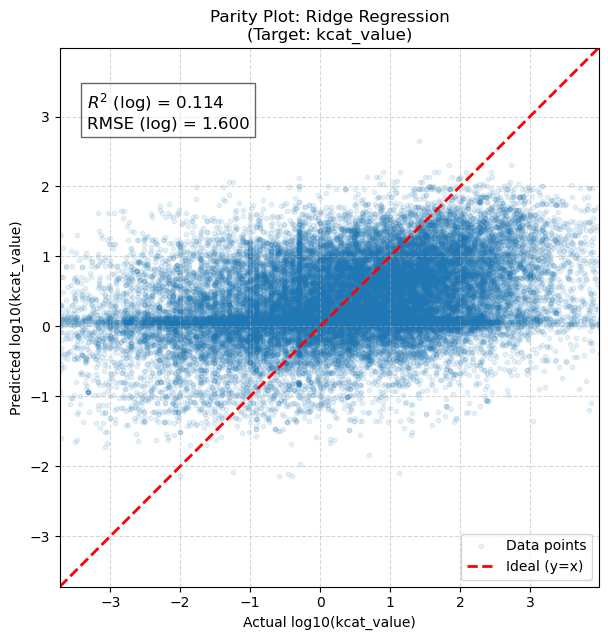

[saved] ./figs\parity_plot_kcat_value_random_forest.png


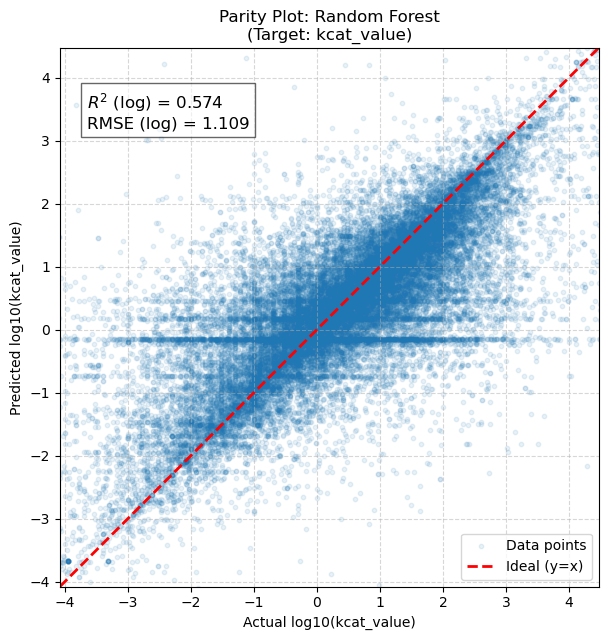


--- 步骤 5: 绘制特征重要性 (来自 RF) ---
Top 5 most important features for kcat_value:
              feature  importance
3            pH_value    0.091342
2       temperature_C    0.076362
33          desc_LogP    0.018294
7   instability_index    0.018159
14               aa_C    0.017359


C:\Users\admin\AppData\Local\Temp\ipykernel_36764\623865425.py:131: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(



[saved] ./figs\feature_importance_top20_kcat_value.png


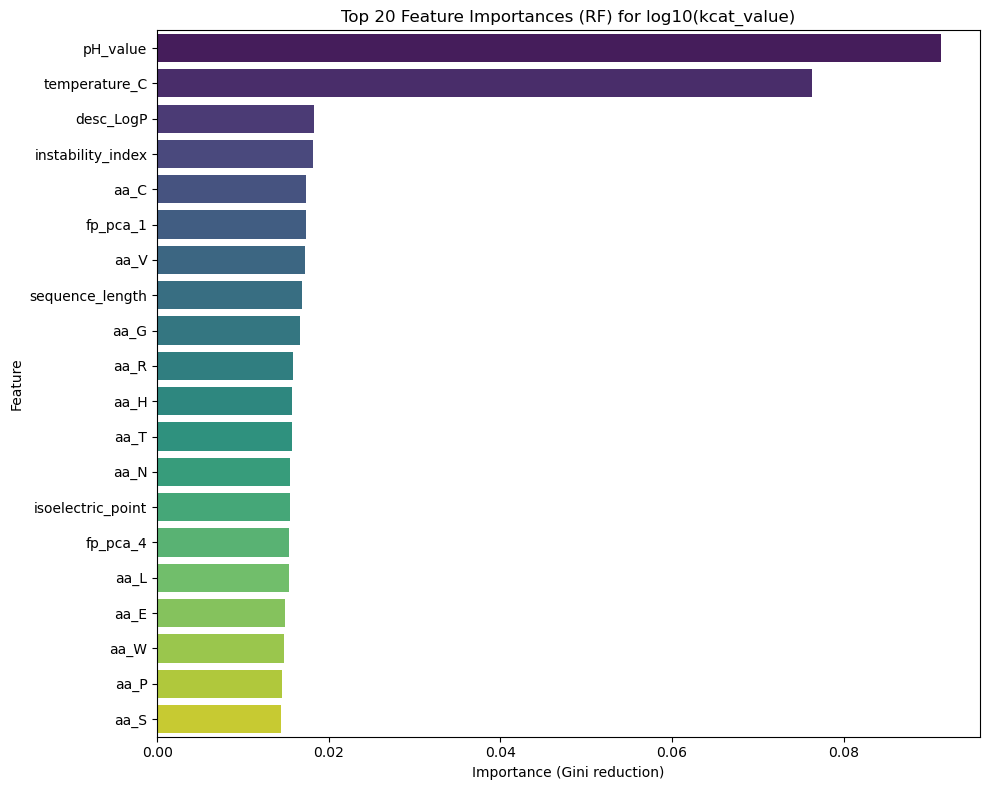



=== [开始] 建模流程: 目标 = km_value ===

--- 步骤 1: 成功从 y['km_value'] 获取数据 ---
过滤无效y值后 X_final 形状: (162371, 241)
过滤无效y值后 y_final 形状: (162371,)
数据划分为 129896 训练 / 32475 测试 样本。

--- 步骤 2: 训练 Ridge (线性) ---
  R^2 (log): 0.1971  | RMSE (log): 1.3156 
  R^2 (orig): -0.0001

--- 步骤 3: 训练 Random Forest (非线性) ---
(正在训练...)
  OOB R^2 (log): 0.6228
  R^2 (log): 0.6219  | RMSE (log): 0.9029 
  R^2 (orig): 0.0004 

--- 步骤 4: 绘制 Parity Plots (显示 Log 指标) ---
[saved] ./figs\parity_plot_km_value_ridge_regression.png


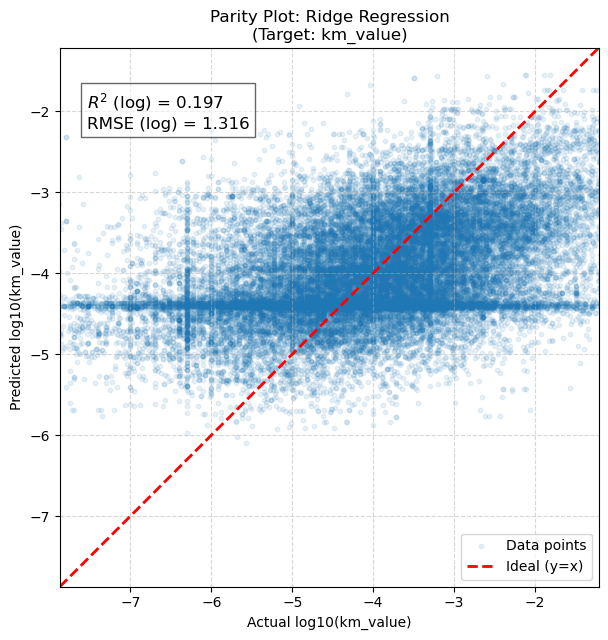

[saved] ./figs\parity_plot_km_value_random_forest.png


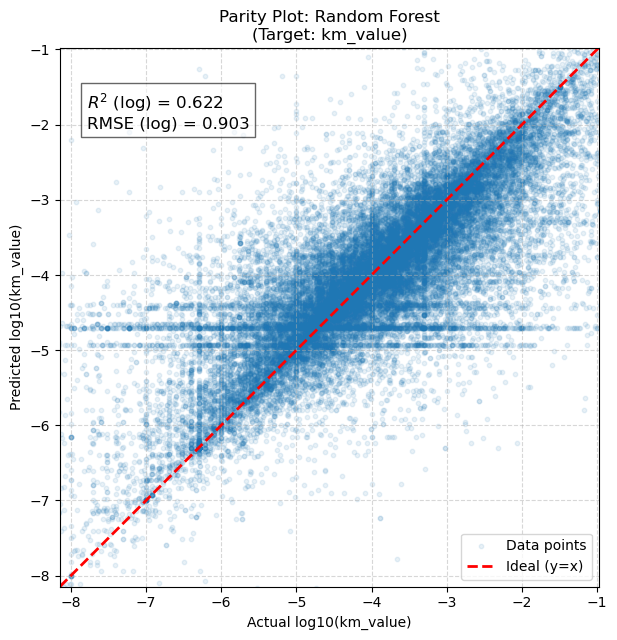


--- 步骤 5: 绘制特征重要性 (来自 RF) ---
Top 5 most important features for km_value:
              feature  importance
39        desc_log_MW    0.096201
3            pH_value    0.077533
2       temperature_C    0.062473
43           fp_pca_2    0.046246
7   instability_index    0.017437


C:\Users\admin\AppData\Local\Temp\ipykernel_36764\623865425.py:131: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(



[saved] ./figs\feature_importance_top20_km_value.png


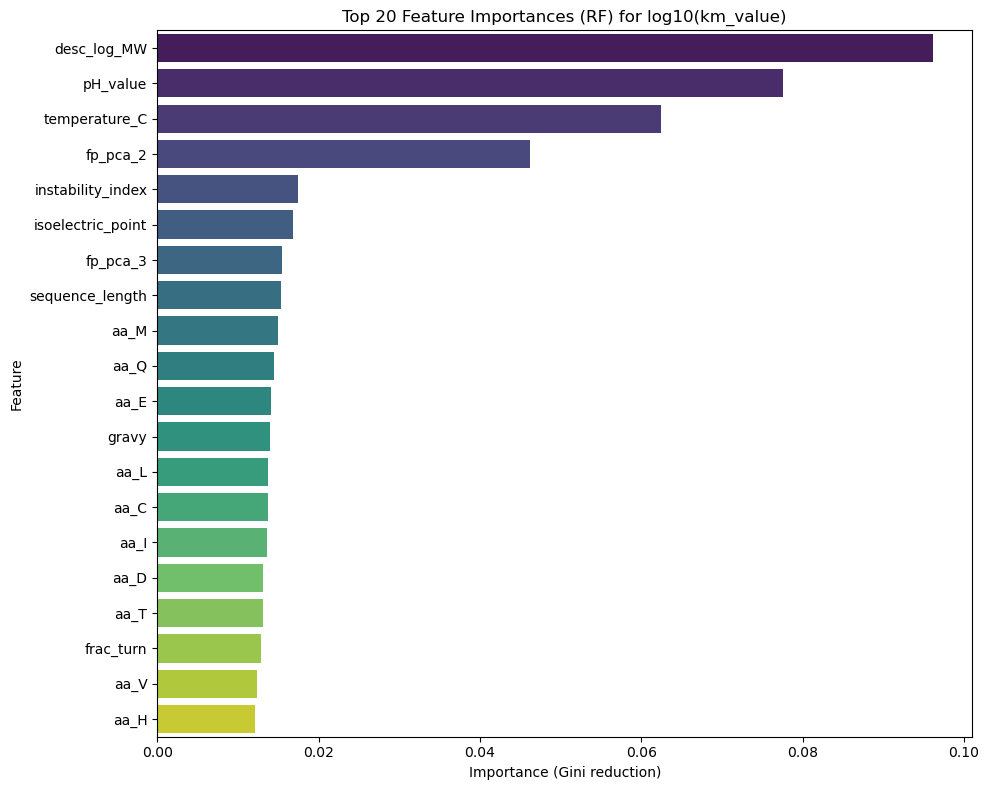



=== [开始] 建模流程: 目标 = kcat_km ===

--- 步骤 1: 动态计算 'kcat_km' ---
成功从 y['kcat_value'] / y['km_value'] 动态计算 'kcat_km'。
过滤无效y值后 X_final 形状: (162371, 241)
过滤无效y值后 y_final 形状: (162371,)
数据划分为 129896 训练 / 32475 测试 样本。

--- 步骤 2: 训练 Ridge (线性) ---
  R^2 (log): 0.0728  | RMSE (log): 1.9336 
  R^2 (orig): -0.0000

--- 步骤 3: 训练 Random Forest (非线性) ---
(正在训练...)
  OOB R^2 (log): 0.5400
  R^2 (log): 0.5374  | RMSE (log): 1.3658 
  R^2 (orig): -0.0000

--- 步骤 4: 绘制 Parity Plots (显示 Log 指标) ---
[saved] ./figs\parity_plot_kcat_km_ridge_regression.png


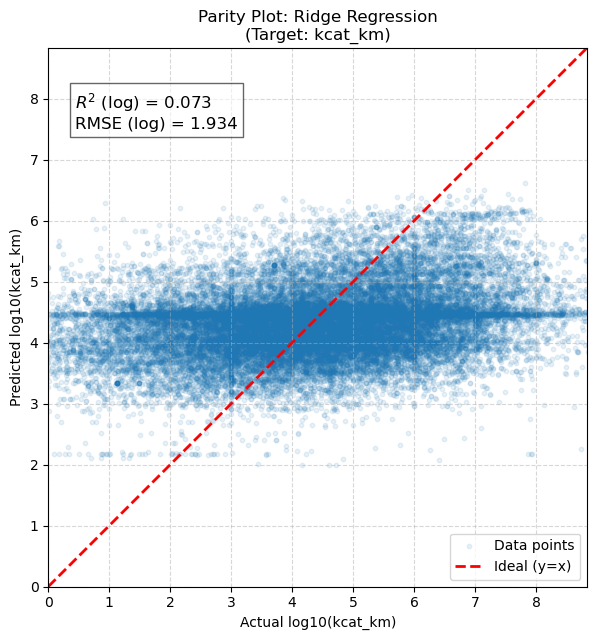

[saved] ./figs\parity_plot_kcat_km_random_forest.png


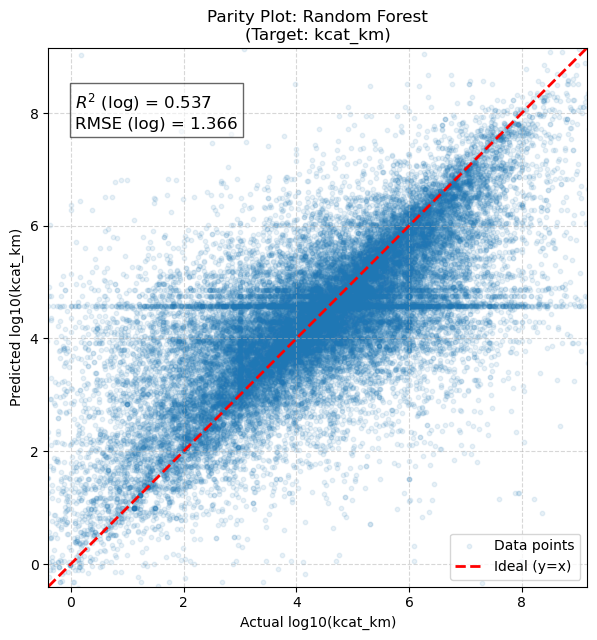


--- 步骤 5: 绘制特征重要性 (来自 RF) ---
Top 5 most important features for kcat_km:
            feature  importance
3          pH_value    0.094919
2     temperature_C    0.074618
39      desc_log_MW    0.021466
30             aa_V    0.018895
4   sequence_length    0.017094


C:\Users\admin\AppData\Local\Temp\ipykernel_36764\623865425.py:131: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(



[saved] ./figs\feature_importance_top20_kcat_km.png


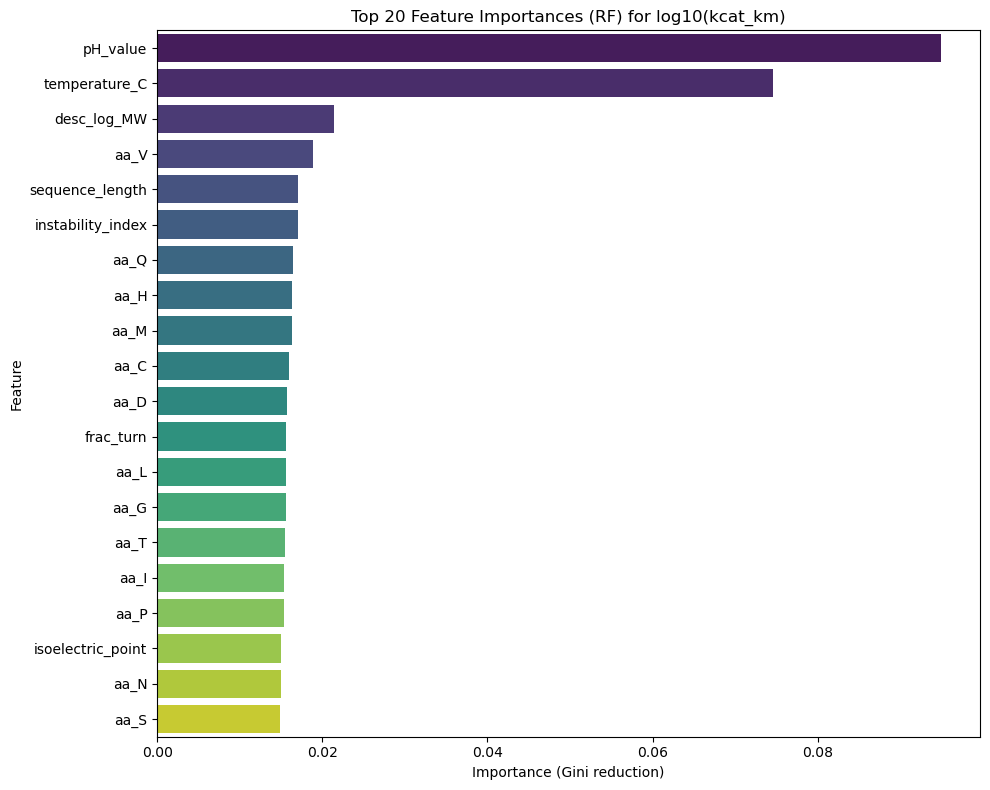



=== [完成] 所有目标建模完毕 ===


In [ ]:
# ============================================
# 6. Ridge + RF for all targets
# ============================================

# X : (n_samples, n_features) 
# y ：{'kcat_value': array, 'km_value': array, 'kcat_km': None}

ALL_TARGETS_TO_MODEL = ['kcat_value', 'km_value', 'kcat_km']

results_summary = {}

for target_name in ALL_TARGETS_TO_MODEL:
    print(f"\n\n========================================================")
    print(f"=== Mpdelling start: Target = {target_name} ===")
    print(f"========================================================\n")

    y_raw = None
    
    # --- 1. calculate y_raw ---
    
    if target_name == 'kcat_km':
        print("--- Step 1: calculate 'kcat_km' ---")
        if y['kcat_value'] is not None and y['km_value'] is not None:
        
            y_kcat = y['kcat_value']
            y_km = y['km_value']
            
            # calculate kcat_km 
            with np.errstate(divide='ignore', invalid='ignore'):
                y_raw = y_kcat / y_km
            print(f"Calcukate y['kcat_value'] / y['km_value'] to get 'kcat_km'。")
        else:
            print(f"False: Failed to calculate 'kcat_km'，as one of y['kcat_value']  y['km_value'] is None。")
            print("Successfully found kcat_value and km_value, skipping...")
            continue
    
    else:
    
        if y[target_name] is not None:
            y_raw = y[target_name]
            print(f"--- Step 1  get data from y['{target_name}'] ---")
        else:
            print(f"False: Target '{target_name}' not found in Y, skipping...")
            continue
            
    # filter 'kcat_km' NaN or inf
    valid_mask = (~np.isnan(y_raw)) & (y_raw > 0) & (np.isfinite(y_raw))
    X_final = X[valid_mask]
    y_final = y_raw[valid_mask]

    if len(y_final) == 0:
        print(f"Target '{target_name}' has no valide y, skipping...")
        continue
        
    print(f"X_final shaoe: {X_final.shape}")
    print(f"y_final shape: {y_final.shape}")

    # --- 3. Log-Transform Y ---
    y_log = np.log10(y_final)

    # --- 4. split training and test set ---
    X_train, X_test, y_train_log, y_test_log = train_test_split(
        X_final, y_log, test_size=0.2, random_state=RANDOM_STATE
    )
    y_test_orig = 10**y_test_log 
    print(f"data split to {len(y_train_log)} train / {len(y_test_orig)} ")

    # --- 5. train and evaluate Ridge ---
    print("\n--- 步骤 2: 训练 Ridge (线性) ---")
    ridge_model = Ridge(alpha=1.0, random_state=RANDOM_STATE)
    ridge_model.fit(X_train, y_train_log)
    y_pred_log_ridge = ridge_model.predict(X_test)
    y_pred_orig_ridge = 10**y_pred_log_ridge
    
    # Log scale
    r2_log_ridge = r2_score(y_test_log, y_pred_log_ridge)
    rmse_log_ridge = np.sqrt(mean_squared_error(y_test_log, y_pred_log_ridge))
    # original scale
    r2_orig_ridge = r2_score(y_test_orig, y_pred_orig_ridge)
    
    print(f"  R^2 (log): {r2_log_ridge:<7.4f} | RMSE (log): {rmse_log_ridge:<7.4f}")
    print(f"  R^2 (orig): {r2_orig_ridge:<7.4f}")

    # --- 6. train and evaluate Random Forest ---
    print("\n--- step 3: Train Random Forest  ---")
    print("(Training...)")
    rf_model = RandomForestRegressor(
        n_estimators=100, random_state=RANDOM_STATE, n_jobs=-1, oob_score=True
    )
    rf_model.fit(X_train, y_train_log)
    y_pred_log_rf = rf_model.predict(X_test)
    y_pred_orig_rf = 10**y_pred_log_rf

    # Log scale
    r2_log_rf = r2_score(y_test_log, y_pred_log_rf)
    rmse_log_rf = np.sqrt(mean_squared_error(y_test_log, y_pred_log_rf))
    # original scale
    r2_orig_rf = r2_score(y_test_orig, y_pred_orig_rf)
    
    print(f"  OOB R^2 (log): {rf_model.oob_score_:.4f}")
    print(f"  R^2 (log): {r2_log_rf:<7.4f} | RMSE (log): {rmse_log_rf:<7.4f}")
    print(f"  R^2 (orig): {r2_orig_rf:<7.4f}")
    
    # --- save result ---
    results_summary[target_name] = {
        "Ridge": {"R2_log": r2_log_ridge, "RMSE_log": rmse_log_ridge, "R2_orig": r2_orig_ridge},
        "RF": {"R2_log": r2_log_rf, "RMSE_log": rmse_log_rf, "R2_orig": r2_orig_rf}
    }

    # ---plot Parity Plots  ---
    print("\n--- step 4: plot Parity Plots with Log ---")
    plot_parity_LOG_METRICS(y_test_orig, y_pred_orig_ridge, "Ridge Regression", target_name)
    plot_parity_LOG_METRICS(y_test_orig, y_pred_orig_rf, "Random Forest", target_name)

    # --- 9. plot feature importance ---
    print("\n--- step5 5: feature importance of RF ---")
    importances = rf_model.feature_importances_
    feat_imp_df = pd.DataFrame({
        'feature': all_feature_names_in_model_X,
        'importance': importances
    }).sort_values(by='importance', ascending=False)

    print(f"Top 5 most important features for {target_name}:")
    print(feat_imp_df.head(5).to_string())

    plt.figure(figsize=(10, 8))
    sns.barplot(
        x='importance', y='feature', 
        data=feat_imp_df.head(20), 
        palette='viridis'
    )
    plt.title(f"Top 20 Feature Importances (RF) for log10({target_name})")
    plt.xlabel("Importance (Gini reduction)")
    plt.ylabel("Feature")
    plt.tight_layout()

    out = os.path.join(FIG_DIR, f"feature_importance_top20_{target_name}.png")
    plt.savefig(out, dpi=200)
    print(f"\n[saved] {out}")
    plt.show() 
    
print("\n\n=== Completed!! ===")

In [ ]:
# ============================================
# 7: result summary
# ============================================

print("\n\n========================================================")
print(f"=== result summary of modelling ===")
print(f"========================================================\n")
print("Compare R-squared (R2_log) in Log scale")
print("R2_log best evaluation mmetric\n")

if not results_summary:
    print("Failed")
else:
    summary_data = []
    for target, models in results_summary.items():
        for model_name, metrics in models.items():
            summary_data.append({
                "Target": target,
                "Model": model_name,
                "R2 (log)": metrics.get('R2_log', np.nan),
                "RMSE (log)": metrics.get('RMSE_log', np.nan),
                "R2 (orig)": metrics.get('R2_orig', np.nan),
            })
    
    summary_df = pd.DataFrame(summary_data)
    
    # Markdown printing
    print(summary_df.to_markdown(index=False, floatfmt=".4f"))



=== [最终摘要] 自动化建模流程 ===

比较所有模型在 Log 尺度上的 R-squared (R2_log)
R2_log 是评估此类数据的最佳指标

| Target     | Model   |   R2 (log) |   RMSE (log) |   R2 (orig) |
|:-----------|:--------|-----------:|-------------:|------------:|
| kcat_value | Ridge   |     0.1135 |       1.5997 |     -0.0001 |
| kcat_value | RF      |     0.5738 |       1.1092 |     -0.0001 |
| km_value   | Ridge   |     0.1971 |       1.3156 |     -0.0001 |
| km_value   | RF      |     0.6219 |       0.9029 |      0.0004 |
| kcat_km    | Ridge   |     0.0728 |       1.9336 |     -0.0000 |
| kcat_km    | RF      |     0.5374 |       1.3658 |     -0.0000 |


In [ ]:
# ============================================
# 8: Import ML libs for hyperparameter tuning
# ============================================

import lightgbm as lgb
import xgboost as xgb
import optuna

from sklearn.model_selection import train_test_split as tune_split

optuna.logging.set_verbosity(optuna.logging.WARNING)

print("XGBoost, LightGBM, Optuna 导入成功。")

XGBoost, LightGBM, Optuna 导入成功。


In [ ]:

# =====
# ============================================
# 9:1 - Random Forest Tuning
# ============================================

RANDOM_STATE = 42 
N_JOBS = -1 

def tune_rf(X_train_full, y_train_full, n_trials=15, tune_sample_size=30000):    """
    print(f"[RF Tuning] 开始 {n_trials} 次试验...")

    # --- 高效修改 1: 创建一个小的子集 *仅用于调优* ---
    if len(X_train_full) > tune_sample_size:
        print(f"[RF Tuning] 数据量过大 ({len(X_train_full)}). 仅使用 {tune_sample_size} 个样本进行快速调优...")
        # 我们使用 tune_split (即 train_test_split) 来获取一个随机样本
        X_tune_subset, _, y_tune_subset, _ = tune_split(
            X_train_full, y_train_full, 
            train_size=tune_sample_size, 
            random_state=RANDOM_STATE
        )
    else:
        # 如果数据量本来就小, 就使用全部数据
        X_tune_subset = X_train_full
        y_tune_subset = y_train_full
    # --- 修改结束 ---

    # 1. 为调优创建内部 训练/验证 划分 (现在在 *子集* 上进行)
    X_train_tune, X_val_tune, y_train_tune, y_val_tune = tune_split(
        X_tune_subset, y_tune_subset, test_size=0.25, random_state=RANDOM_STATE
    )

    # 2. 定义 Optuna 'objective' 函数
    def objective(trial):
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 100, 400),
            'max_depth': trial.suggest_int('max_depth', 10, 50),
            'max_features': trial.suggest_float('max_features', 0.2, 1.0),
            'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10, log=True),
        }
        
        # (这现在是在一个很小的 'X_train_tune' 数据集上训练, 会非常快)
        model = RandomForestRegressor(
            **params, 
            random_state=RANDOM_STATE, 
            n_jobs=N_JOBS
        )
        model.fit(X_train_tune, y_train_tune)
        
        y_pred_val = model.predict(X_val_tune)
        rmse = np.sqrt(mean_squared_error(y_val_tune, y_pred_val))
        return rmse

    # 3. 运行 Optuna 调优 (现在会非常快)
    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=n_trials, show_progress_bar=True)
    
    best_params = study.best_params
    print(f"[RF Tuning] 在 *子集* 上找到最优参数: {best_params}")
    print(f"[RF Tuning] 在 *子集* 上最优验证 RMSE (log): {study.best_value:.4f}")

    # 4. 在 *全部* 训练数据上重新训练最终模型
    # (这仍然会花费 6-7 分钟, 但我们只做这一次, 而不是 15 次)
    print("[RF Tuning] 正在使用最优参数在 *完整* 训练集上重新训练...")
    final_model = RandomForestRegressor(
        **best_params,
        random_state=RANDOM_STATE,
        n_jobs=N_JOBS
    )
    final_model.fit(X_train_full, y_train_full)
    
    return final_model

print("定义 'tune_rf' (高效版-子集调优) 函数成功。")

定义 'tune_rf' (调优RF) 函数成功。


In [16]:
# ============================================
# 单元格 10: 模型方法 2 - LightGBM 调优函数 (已二次修正)
# ============================================
# (全局变量, 请勿修改)
RANDOM_STATE = 42
GPU_ENABLED = False 

def tune_lgbm(X_train_full, y_train_full, n_trials=25):
    """
    使用 Optuna 和早停 (Early Stopping) 自动调优 LightGBM。
    
    n_trials: 调优的试验次数 (设置 25-50 次以获得良好平衡)
    """
    print(f"[LGBM Tuning] 开始 {n_trials} 次试验...")
    
    X_train_tune, X_val_tune, y_train_tune, y_val_tune = tune_split(
        X_train_full, y_train_full, test_size=0.25, random_state=RANDOM_STATE
    )
    dtrain = lgb.Dataset(X_train_tune, label=y_train_tune)
    dval = lgb.Dataset(X_val_tune, label=y_val_tune)

    def objective(trial):
        params = {
            'objective': 'regression_l1', 
            'metric': 'rmse',
            'verbosity': -1,
            'n_jobs': -1,
            'random_state': RANDOM_STATE,
            'device_type': 'gpu' if GPU_ENABLED else 'cpu',
            
            # --- [!!! 二次修正点 !!!] ---
            # 根据 LightGBMError 报错信息, 
            # 当动态改变 min_child_samples 时, 必须禁用 feature_pre_filter
            'feature_pre_filter': False,
            # --- [修正结束] ---

            'n_estimators': 2000, 
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2, log=True),
            'num_leaves': trial.suggest_int('num_leaves', 20, 300),
            'reg_alpha': trial.suggest_float('reg_alpha', 1e-3, 10.0, log=True),
            'reg_lambda': trial.suggest_float('reg_lambda', 1e-3, 10.0, log=True),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.4, 1.0),
            'subsample': trial.suggest_float('subsample', 0.4, 1.0),
            'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        }

        # 第一次修正 (来自上一个错误)
        pruning_callback = optuna.integration.LightGBMPruningCallback(
            trial, 
            'rmse', 
            valid_name='validation'
        )
        
        model = lgb.train(
            params,
            dtrain,
            valid_sets=[dval],
            valid_names=['validation'], 
            callbacks=[
                lgb.early_stopping(50, verbose=False),
                pruning_callback
            ]
        )
        
        return model.best_score['validation']['rmse']

    study = optuna.create_study(direction='minimize', pruner=optuna.pruners.MedianPruner())
    study.optimize(objective, n_trials=n_trials, show_progress_bar=True)
    
    best_params = study.best_params
    best_n_estimators = study.best_trial.user_attrs.get('best_iteration', 2000)
    best_params['n_estimators'] = best_n_estimators

    print(f"[LGBM Tuning] 找到最优参数: {best_params}")
    print(f"[LGBM Tuning] 最优验证 RMSE (log): {study.best_value:.4f}")

    print("[LGBM Tuning] 正在使用最优参数在完整训练集上重新训练...")
    final_model = lgb.LGBMRegressor(
        **best_params,
        objective='regression_l1',
        device_type='gpu' if GPU_ENABLED else 'cpu',
        random_state=RANDOM_STATE,
        n_jobs=-1
    )
    final_model.fit(X_train_full, y_train_full)
    
    return final_model

print("定义 'tune_lgbm' (已二次修正) 函数成功。")

定义 'tune_lgbm' (已二次修正) 函数成功。


In [27]:
# ============================================
# 单元格 11: 模型方法 3 - XGBoost 调优函数 (已四次修正)
# ============================================
# (全局变量, 请勿修改)
RANDOM_STATE = 42
GPU_ENABLED = False 

def tune_xgb(X_train_full, y_train_full, n_trials=25):
    """
    使用 Optuna 和早停 (Early Stopping) 自动调优 XGBoost。
    
    n_trials: 调优的试验次数 (设置 25-50 次以获得良好平衡)
    """
    print(f"[XGB Tuning] 开始 {n_trials} 次试验...")
    
    X_train_tune, X_val_tune, y_train_tune, y_val_tune = tune_split(
        X_train_full, y_train_full, test_size=0.25, random_state=RANDOM_STATE
    )

    def objective(trial):
        params = {
            'objective': 'reg:squarederror',
            'eval_metric': 'rmse',
            'verbosity': 0,
            'random_state': RANDOM_STATE,
            'tree_method': 'gpu_hist' if GPU_ENABLED else 'hist', # (此处的语法是正确的)
            'n_estimators': 2000, 
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2, log=True),
            'max_depth': trial.suggest_int('max_depth', 3, 12),
            'reg_alpha': trial.suggest_float('reg_alpha', 1e-3, 10.0, log=True),
            'reg_lambda': trial.suggest_float('reg_lambda', 1e-3, 10.0, log=True),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.4, 1.0),
            'subsample': trial.suggest_float('subsample', 0.4, 1.0),
            'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
            'early_stopping_rounds': 50 
        }
        
        model = xgb.XGBRegressor(**params)
        
        model.fit(
            X_train_tune, y_train_tune,
            eval_set=[(X_val_tune, y_val_tune)],
            verbose=False
        )
        
        return model.best_score

    study = optuna.create_study(direction='minimize') 
    study.optimize(objective, n_trials=n_trials, show_progress_bar=True)
    
    best_params = study.best_params
    best_params['n_estimators'] = study.best_trial.best_iteration
    
    print(f"[XGB Tuning] 找到最优参数: {best_params}")
    print(f"[XGB Tuning] 最优验证 RMSE (log): {study.best_value:.4f}")

    print("[XGB Tuning] 正在使用最优参数在完整训练集上重新训练...")
    final_model = xgb.XGBRegressor(
        **best_params,
        objective='reg:squarederror',
        
        # --- [!!! 修正点 !!!] ---
        # 修复了 SyntaxError
        # (冒号 ':' 已更改为 等号 '=')
        tree_method='gpu_hist' if GPU_ENABLED else 'hist',
        # --- [修正结束] ---
        
        random_state=RANDOM_STATE,
    )
    final_model.fit(X_train_full, y_train_full)
    
    return final_model

print("定义 'tune_xgb' (已四次修正) 函数成功。")

定义 'tune_xgb' (已四次修正) 函数成功。


In [12]:
# ============================================
# 单元格 12: 自动化建模循环 
# ============================================

# X 和 y 字典已在 单元格 4 中被全局定义
ALL_TARGETS_TO_MODEL = ['kcat_value', 'km_value', 'kcat_km']

# 这是一个 *新* 的字典, 用来存储 *调优后* 模型的结果
tuned_results_summary = {}

# --- 设置每个模型调优的试验次数 ---
# (您可以根据需要增加或减少这些值，调优次数越多，结果越好，但时间越长)
# (为了快速演示，我设置了较小的值)
N_TRIALS_RF = 15
N_TRIALS_LGBM = 20
N_TRIALS_XGB = 20


for target_name in ALL_TARGETS_TO_MODEL:
    print(f"\n\n===============================================================")
    print(f"=== [开始 高级调优流程]: 目标 = {target_name} ===")
    print(f"===============================================================\n")

    y_raw = None
    
    # --- 1. 动态获取/计算 y_raw (与单元格 6 相同的逻辑) ---
    if target_name == 'kcat_km':
        print("--- 步骤 1: 动态计算 'kcat_km' ---")
        if y['kcat_value'] is not None and y['km_value'] is not None:
            y_kcat, y_km = y['kcat_value'], y['km_value']
            with np.errstate(divide='ignore', invalid='ignore'):
                y_raw = y_kcat / y_km
            print(f"成功从 y['kcat_value'] / y['km_value'] 动态计算 'kcat_km'。")
        else:
            print(f"错误: 无法计算 'kcat_km'。跳过此目标。")
            continue
    else:
        if y[target_name] is not None:
            y_raw = y[target_name]
            print(f"--- 步骤 1: 成功从 y['{target_name}'] 获取数据 ---")
        else:
            print(f"错误: 目标 '{target_name}' 在 y 字典中未找到。跳过此目标。")
            continue
            
    # --- 2. 过滤无效的 y 值 ---
    valid_mask = (~np.isnan(y_raw)) & (y_raw > 0) & (np.isfinite(y_raw))
    X_final = X[valid_mask]
    y_final = y_raw[valid_mask]

    if len(y_final) == 0:
        print(f"目标 '{target_name}' 没有有效的 y 值。跳过此目标。")
        continue
        
    print(f"过滤无效y值后 X_final 形状: {X_final.shape}")
    y_log = np.log10(y_final)

    # --- 3. 划分训练集和测试集 ---
    X_train, X_test, y_train_log, y_test_log = train_test_split(
        X_final, y_log, test_size=0.2, random_state=RANDOM_STATE
    )
    y_test_orig = 10**y_test_log
    print(f"数据划分为 {len(y_train_log)} 训练 / {len(y_test_orig)} 测试 样本。")

    # --- 4. 自动化调优和训练 ---
    # (这会调用 单元格 9, 10, 11 中定义的函数)
    
    # --- 4a. Random Forest ---
    rf_model = tune_rf(X_train, y_train_log, n_trials=N_TRIALS_RF)
    y_pred_log_rf = rf_model.predict(X_test)
    y_pred_orig_rf = 10**y_pred_log_rf
    
    # --- 4b. LightGBM ---
    lgbm_model = tune_lgbm(X_train, y_train_log, n_trials=N_TRIALS_LGBM)
    y_pred_log_lgbm = lgbm_model.predict(X_test)
    y_pred_orig_lgbm = 10**y_pred_log_lgbm
    
    # --- 4c. XGBoost ---
    xgb_model = tune_xgb(X_train, y_train_log, n_trials=N_TRIALS_XGB)
    y_pred_log_xgb = xgb_model.predict(X_test)
    y_pred_orig_xgb = 10**y_pred_log_xgb

    # --- 5. 评估和存储所有模型 ---
    print(f"\n--- 评估结果 (目标: {target_name}) ---")
    models_to_eval = {
        "RF (Tuned)": (y_pred_log_rf, y_pred_orig_rf),
        "LGBM (Tuned)": (y_pred_log_lgbm, y_pred_orig_lgbm),
        "XGB (Tuned)": (y_pred_log_xgb, y_pred_orig_xgb)
    }
    
    if target_name not in tuned_results_summary:
        tuned_results_summary[target_name] = {}

    for model_name, (y_pred_log, y_pred_orig) in models_to_eval.items():
        r2_log = r2_score(y_test_log, y_pred_log)
        rmse_log = np.sqrt(mean_squared_error(y_test_log, y_pred_log))
        r2_orig = r2_score(y_test_orig, y_pred_orig)
        
        print(f"  {model_name:<12} | R^2 (log): {r2_log:<7.4f} | R^2 (orig): {r2_orig:<7.4f}")
        
        tuned_results_summary[target_name][model_name] = {
            "R2_log": r2_log, "RMSE_log": rmse_log, "R2_orig": r2_orig
        }

    # --- 6. 绘制所有模型的 Parity Plots ---
    # (我们使用 单元格 6 中定义的 `plot_parity_LOG_METRICS` 函数)
    print(f"\n--- 绘制 Parity Plots (目标: {target_name}) ---")
    plot_parity_LOG_METRICS(y_test_orig, y_pred_orig_rf, "Random Forest (Tuned)", target_name)
    plot_parity_LOG_METRICS(y_test_orig, y_pred_orig_lgbm, "LightGBM (Tuned)", target_name)
    plot_parity_LOG_METRICS(y_test_orig, y_pred_orig_xgb, "XGBoost (Tuned)", target_name)

    # --- 7. 绘制特征重要性 (来自最好的模型) ---
    best_model_name = max(tuned_results_summary[target_name], 
                          key=lambda m: tuned_results_summary[target_name][m]['R2_log'])
    print(f"\n--- 绘制特征重要性 (来自 {best_model_name}) ---")
    
    if "RF" in best_model_name:
        importances = rf_model.feature_importances_
    elif "LGBM" in best_model_name:
        importances = lgbm_model.feature_importances_
    elif "XGB" in best_model_name:
        importances = xgb_model.feature_importances_

    # (我们使用 单元格 6 中定义的 `all_feature_names_in_model_X`)
    feat_imp_df = pd.DataFrame({
        'feature': all_feature_names_in_model_X,
        'importance': importances
    }).sort_values(by='importance', ascending=False)
    
    plt.figure(figsize=(10, 8))
    sns.barplot(x='importance', y='feature', data=feat_imp_df.head(20), palette='viridis')
    plt.title(f"Top 20 Features (from {best_model_name}) for log10({target_name})")
    plt.xlabel("Importance")
    plt.ylabel("Feature")
    plt.tight_layout()

    out = os.path.join(FIG_DIR, f"feature_importance_top20_TUNED_{target_name}.png")
    plt.savefig(out, dpi=200)
    print(f"\n[saved] {out}")
    plt.show()

print("\n\n=== [完成] 所有目标和高级模型调优完毕 ===")



=== [开始 高级调优流程]: 目标 = kcat_value ===

--- 步骤 1: 成功从 y['kcat_value'] 获取数据 ---
过滤无效y值后 X_final 形状: (162371, 241)
数据划分为 129896 训练 / 32475 测试 样本。
[RF Tuning] 开始 15 次试验...


  0%|          | 0/15 [00:00<?, ?it/s]

[RF Tuning] 找到最优参数: {'n_estimators': 300, 'max_depth': 38, 'max_features': 0.6691903151072935, 'min_samples_leaf': 1}
[RF Tuning] 最优验证 RMSE (log): 1.1397
[RF Tuning] 正在使用最优参数在完整训练集上重新训练...
[LGBM Tuning] 开始 20 次试验...


  0%|          | 0/20 [00:00<?, ?it/s]

[W 2025-10-26 16:27:29,501] Trial 0 failed with parameters: {'learning_rate': 0.13605719387707055, 'num_leaves': 88, 'reg_alpha': 2.201090580761702, 'reg_lambda': 0.41447851920368284, 'colsample_bytree': 0.477258432052009, 'subsample': 0.5085999853266311, 'min_child_samples': 11} because of the following error: ModuleNotFoundError('\nCould not find `optuna-integration` for `lightgbm`.\nPlease run `pip install optuna-integration[lightgbm]`.').
Traceback (most recent call last):
  File "c:\Users\admin\anaconda3\Lib\site-packages\optuna\integration\lightgbm.py", line 11, in <module>
    import optuna_integration.lightgbm as lgb
ModuleNotFoundError: No module named 'optuna_integration'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "c:\Users\admin\anaconda3\Lib\site-packages\optuna\integration\__init__.py", line 132, in _get_module
    return importlib.import_module("." + module_name, self.__name__)
           ^^^^^^^^^^^^^^^

ModuleNotFoundError: 
Could not find `optuna-integration` for `lightgbm`.
Please run `pip install optuna-integration[lightgbm]`.

Random forest结果：
[RF Tuning] 找到最优参数: {'n_estimators': 300, 'max_depth': 38, 'max_features': 0.6691903151072935, 'min_samples_leaf': 1}
[RF Tuning] 最优验证 RMSE (log): 1.1397

1.1397 (调优验证) 略高于 1.1092 (基线测试)

In [ ]:
# ============================================
# 单元格 12: (新) 自动化调优 - 仅 Random Forest
# ============================================

# --- 全局设置 ---
# ( 单元格 4 已定义 X, y, meta; 单元格 6 已定义绘图函数 )
ALL_TARGETS_TO_MODEL = ['kcat_value', 'km_value', 'kcat_km']
N_TRIALS_RF = 15 # (您可以调整此值)

# --- 全局结果字典 ---
# 我们检查它是否存在, 如果不存在, 就创建它
# 这允许您独立地重新运行此单元格
if 'tuned_results_summary' not in globals():
    tuned_results_summary = {}

print(f"===============================================================")
print(f"=== [开始] 模型 1: Random Forest (调优试验: {N_TRIALS_RF} 次) ===")
print(f"===============================================================\n")

for target_name in ALL_TARGETS_TO_MODEL:
    print(f"\n--- [RF] 开始处理目标: {target_name} ---")
    
    # --- 1. 动态获取/计算 y_raw (与旧 单元格 12 相同的逻辑) ---
    y_raw = None
    if target_name == 'kcat_km':
        if y['kcat_value'] is not None and y['km_value'] is not None:
            y_kcat, y_km = y['kcat_value'], y['km_value']
            with np.errstate(divide='ignore', invalid='ignore'):
                y_raw = y_kcat / y_km
        else:
            print(f"  [跳过] 无法计算 'kcat_km'。")
            continue
    else:
        if y[target_name] is not None:
            y_raw = y[target_name]
        else:
            print(f"  [跳过] 目标 '{target_name}' 在 y 字典中未找到。")
            continue
            
    # --- 2. 过滤无效的 y 值 ---
    valid_mask = (~np.isnan(y_raw)) & (y_raw > 0) & (np.isfinite(y_raw))
    X_final = X[valid_mask]
    y_final = y_raw[valid_mask]
    if len(y_final) == 0:
        print(f"  [跳过] 目标 '{target_name}' 没有有效的 y 值。")
        continue
    y_log = np.log10(y_final)

    # --- 3. 划分训练集和测试集 ---
    X_train, X_test, y_train_log, y_test_log = train_test_split(
        X_final, y_log, test_size=0.2, random_state=RANDOM_STATE
    )
    y_test_orig = 10**y_test_log
    print(f"  数据: {len(y_train_log)} 训练 / {len(y_test_orig)} 测试")

    # --- 4. 自动化调优和训练 (调用 单元格 9) ---
    rf_model = tune_rf(X_train, y_train_log, n_trials=N_TRIALS_RF)
    y_pred_log_rf = rf_model.predict(X_test)
    y_pred_orig_rf = 10**y_pred_log_rf

    # --- 5. 评估和存储结果 ---
    r2_log = r2_score(y_test_log, y_pred_log_rf)
    rmse_log = np.sqrt(mean_squared_error(y_test_log, y_pred_log_rf))
    r2_orig = r2_score(y_test_orig, y_pred_orig_rf)
    
    print(f"  [RF 结果] R^2 (log): {r2_log:<7.4f} | R^2 (orig): {r2_orig:<7.4f}")
    
    if target_name not in tuned_results_summary:
        tuned_results_summary[target_name] = {}
    tuned_results_summary[target_name]["RF (Tuned)"] = {
        "R2_log": r2_log, "RMSE_log": rmse_log, "R2_orig": r2_orig
    }

    # --- 6. 绘制 Parity Plot (调用 单元格 6 函数) ---
    plot_parity_LOG_METRICS(y_test_orig, y_pred_orig_rf, "Random Forest (Tuned)", target_name)
    
    print(f"--- [RF] 完成目标: {target_name} ---")

print("\n=== [完成] Random Forest 所有目标 ===")

=== [开始] 模型 2: LightGBM (调优试验: 20 次) ===


--- [LGBM] 开始处理目标: kcat_value ---
  数据: 129896 训练 / 32475 测试
[LGBM Tuning] 开始 20 次试验...


  0%|          | 0/20 [00:00<?, ?it/s]

[LGBM Tuning] 找到最优参数: {'learning_rate': 0.10169764295384189, 'num_leaves': 283, 'reg_alpha': 0.059543588571071525, 'reg_lambda': 0.0033084597629306615, 'colsample_bytree': 0.8785715350720864, 'subsample': 0.5694744029339074, 'min_child_samples': 6, 'n_estimators': 2000}
[LGBM Tuning] 最优验证 RMSE (log): 1.2173
[LGBM Tuning] 正在使用最优参数在完整训练集上重新训练...


c:\Users\admin\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


  [LGBM 结果] R^2 (log): 0.5122  | R^2 (orig): -0.0001
[saved] ./figs\parity_plot_kcat_value_lightgbm_(tuned).png


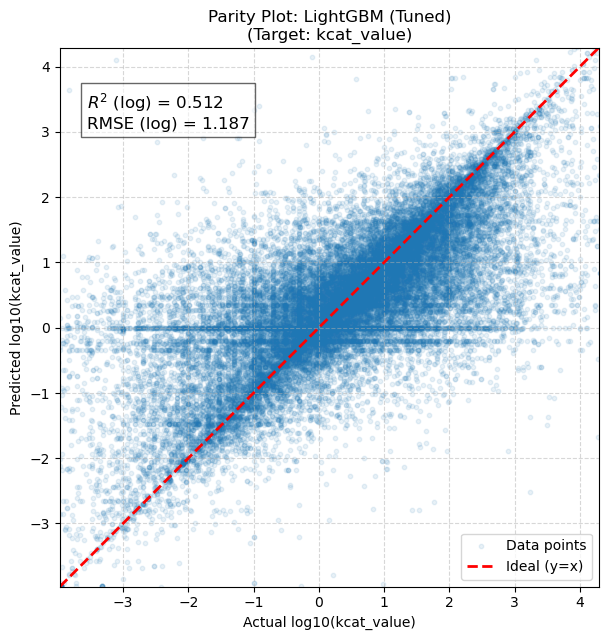

--- [LGBM] 完成目标: kcat_value ---

--- [LGBM] 开始处理目标: km_value ---
  数据: 129896 训练 / 32475 测试
[LGBM Tuning] 开始 20 次试验...


  0%|          | 0/20 [00:00<?, ?it/s]

[W 2025-10-26 17:39:12,998] Trial 1 failed with parameters: {'learning_rate': 0.14932209207548153, 'num_leaves': 26, 'reg_alpha': 0.027087223475656067, 'reg_lambda': 0.07357009493486037, 'colsample_bytree': 0.5197978817213718, 'subsample': 0.5124574927573923, 'min_child_samples': 11} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "c:\Users\admin\anaconda3\Lib\site-packages\optuna\study\_optimize.py", line 201, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\admin\AppData\Local\Temp\ipykernel_36764\426467865.py", line 54, in objective
    model = lgb.train(
            ^^^^^^^^^^
  File "c:\Users\admin\anaconda3\Lib\site-packages\lightgbm\engine.py", line 322, in train
    booster.update(fobj=fobj)
  File "c:\Users\admin\anaconda3\Lib\site-packages\lightgbm\basic.py", line 4155, in update
    _LIB.LGBM_BoosterUpdateOneIter(
KeyboardInterrupt
[W 2025-10-26 17:39:13,005] Trial 1 failed with 

KeyboardInterrupt: 

In [17]:
# ============================================
# 单元格 13: (新) 自动化调优 - LightGBM
# ============================================

# --- 全局设置 ---
ALL_TARGETS_TO_MODEL = ['kcat_value', 'km_value', 'kcat_km']
N_TRIALS_LGBM = 20 # (您可以调整此值)

# --- 全局结果字典 (必须已在 单元格 12 中创建) ---
if 'tuned_results_summary' not in globals():
    print("错误: 'tuned_results_summary' 字典未找到。请先运行 单元格 12。")
    # 或者: tuned_results_summary = {}

print(f"===============================================================")
print(f"=== [开始] 模型 2: LightGBM (调优试验: {N_TRIALS_LGBM} 次) ===")
print(f"===============================================================\n")

for target_name in ALL_TARGETS_TO_MODEL:
    print(f"\n--- [LGBM] 开始处理目标: {target_name} ---")
    
    # --- 1. 动态获取/计算 y_raw ---
    y_raw = None
    if target_name == 'kcat_km':
        if y['kcat_value'] is not None and y['km_value'] is not None:
            y_kcat, y_km = y['kcat_value'], y['km_value']
            with np.errstate(divide='ignore', invalid='ignore'):
                y_raw = y_kcat / y_km
        else:
            print(f"  [跳过] 无法计算 'kcat_km'。")
            continue
    else:
        if y[target_name] is not None:
            y_raw = y[target_name]
        else:
            print(f"  [跳过] 目标 '{target_name}' 在 y 字典中未找到。")
            continue
            
    # --- 2. 过滤无效的 y 值 ---
    valid_mask = (~np.isnan(y_raw)) & (y_raw > 0) & (np.isfinite(y_raw))
    X_final = X[valid_mask]
    y_final = y_raw[valid_mask]
    if len(y_final) == 0:
        print(f"  [跳过] 目标 '{target_name}' 没有有效的 y 值。")
        continue
    y_log = np.log10(y_final)

    # --- 3. 划分训练集和测试集 ---
    X_train, X_test, y_train_log, y_test_log = train_test_split(
        X_final, y_log, test_size=0.2, random_state=RANDOM_STATE
    )
    y_test_orig = 10**y_test_log
    print(f"  数据: {len(y_train_log)} 训练 / {len(y_test_orig)} 测试")

    # --- 4. 自动化调优和训练 (调用 单元格 10) ---
    lgbm_model = tune_lgbm(X_train, y_train_log, n_trials=N_TRIALS_LGBM)
    y_pred_log_lgbm = lgbm_model.predict(X_test)
    y_pred_orig_lgbm = 10**y_pred_log_lgbm

    # --- 5. 评估和存储结果 ---
    r2_log = r2_score(y_test_log, y_pred_log_lgbm)
    rmse_log = np.sqrt(mean_squared_error(y_test_log, y_pred_log_lgbm))
    r2_orig = r2_score(y_test_orig, y_pred_orig_lgbm)
    
    print(f"  [LGBM 结果] R^2 (log): {r2_log:<7.4f} | R^2 (orig): {r2_orig:<7.4f}")
    
    if target_name not in tuned_results_summary:
        tuned_results_summary[target_name] = {}
    tuned_results_summary[target_name]["LGBM (Tuned)"] = {
        "R2_log": r2_log, "RMSE_log": rmse_log, "R2_orig": r2_orig
    }

    # --- 6. 绘制 Parity Plot (调用 单元格 6 函数) ---
    plot_parity_LOG_METRICS(y_test_orig, y_pred_orig_lgbm, "LightGBM (Tuned)", target_name)
    
    print(f"--- [LGBM] 完成目标: {target_name} ---")

print("\n=== [完成] LightGBM 所有目标 ===")

[LGBM Tuning] 找到最优参数: {'learning_rate': 0.10169764295384189, 'num_leaves': 283, 'reg_alpha': 0.059543588571071525, 'reg_lambda': 0.0033084597629306615, 'colsample_bytree': 0.8785715350720864, 'subsample': 0.5694744029339074, 'min_child_samples': 6, 'n_estimators': 2000}
[LGBM Tuning] 最优验证 RMSE (log): 1.2173 R^2 (log): 0.5122

1.2173 (调优验证) 略高于 1.1092 (基线测试)& RF结果 1.1397

In [28]:
# ============================================
# 单元格 14: (新) 自动化调优 - 仅 XGBoost
# ============================================

# --- 全局设置 ---
# ALL_TARGETS_TO_MODEL = ['kcat_value', 'km_value', 'kcat_km']
ALL_TARGETS_TO_MODEL = ['kcat_value']
N_TRIALS_XGB = 20 
# --- 全局结果字典 (必须已在 单元格 12 中创建) ---
if 'tuned_results_summary' not in globals():
    print("错误: 'tuned_results_summary' 字典未找到。请先运行 单元格 12。")
    # 或者: tuned_results_summary = {}

print(f"===============================================================")
print(f"=== [开始] 模型 3: XGBoost (调优试验: {N_TRIALS_XGB} 次) ===")
print(f"===============================================================\n")

for target_name in ALL_TARGETS_TO_MODEL:
    print(f"\n--- [XGB] 开始处理目标: {target_name} ---")
    
    # --- 1. 动态获取/计算 y_raw ---
    y_raw = None
    if target_name == 'kcat_km':
        if y['kcat_value'] is not None and y['km_value'] is not None:
            y_kcat, y_km = y['kcat_value'], y['km_value']
            with np.errstate(divide='ignore', invalid='ignore'):
                y_raw = y_kcat / y_km
        else:
            print(f"  [跳过] 无法计算 'kcat_km'。")
            continue
    else:
        if y[target_name] is not None:
            y_raw = y[target_name]
        else:
            print(f"  [跳过] 目标 '{target_name}' 在 y 字典中未找到。")
            continue
            
    # --- 2. 过滤无效的 y 值 ---
    valid_mask = (~np.isnan(y_raw)) & (y_raw > 0) & (np.isfinite(y_raw))
    X_final = X[valid_mask]
    y_final = y_raw[valid_mask]
    if len(y_final) == 0:
        print(f"  [跳过] 目标 '{target_name}' 没有有效的 y 值。")
        continue
    y_log = np.log10(y_final)

    # --- 3. 划分训练集和测试集 ---
    X_train, X_test, y_train_log, y_test_log = train_test_split(
        X_final, y_log, test_size=0.2, random_state=RANDOM_STATE
    )
    y_test_orig = 10**y_test_log
    print(f"  数据: {len(y_train_log)} 训练 / {len(y_test_orig)} 测试")

    # --- 4. 自动化调优和训练 (调用 单元格 11) ---
    xgb_model = tune_xgb(X_train, y_train_log, n_trials=N_TRIALS_XGB)
    y_pred_log_xgb = xgb_model.predict(X_test)
    y_pred_orig_xgb = 10**y_pred_log_xgb

    # --- 5. 评估和存储结果 ---
    r2_log = r2_score(y_test_log, y_pred_log_xgb)
    rmse_log = np.sqrt(mean_squared_error(y_test_log, y_pred_log_xgb))
    r2_orig = r2_score(y_test_orig, y_pred_orig_xgb)
    
    print(f"  [XGB 结果] R^2 (log): {r2_log:<7.4f} | R^2 (orig): {r2_orig:<7.4f}")
    
    if target_name not in tuned_results_summary:
        tuned_results_summary[target_name] = {}
    tuned_results_summary[target_name]["XGB (Tuned)"] = {
        "R2_log": r2_log, "RMSE_log": rmse_log, "R2_orig": r2_orig
    }

    # --- 6. 绘制 Parity Plot (调用 单元格 6 函数) ---
    plot_parity_LOG_METRICS(y_test_orig, y_pred_orig_xgb, "XGBoost (Tuned)", target_name)
    
    print(f"--- [XGB] 完成目标: {target_name} ---")

print("\n=== [完成] XGBoost 所有目标 ===")

=== [开始] 模型 3: XGBoost (调优试验: 20 次) ===


--- [XGB] 开始处理目标: kcat_value ---
  数据: 129896 训练 / 32475 测试
[XGB Tuning] 开始 20 次试验...


  0%|          | 0/20 [00:00<?, ?it/s]

AttributeError: 'FrozenTrial' object has no attribute 'best_iteration'